[My last post](https://mlops.systems/posts/2024-06-25-evaluation-finetuning-manual-dataset.html) outlined the kinds of evaluation I need and want to understand how
well my finetuned LLM is performing in the task of structured data extraction
from press releases. Let's start with the core metric I'm interested in, accuracy,
and then later we can dive into some of the other evaluation metrics as well.

## TL;DR

The headline for this post could well have been: finetuned models beat OpenAI, but evals were a bit painful to implement. There's a lot of hidden code here in this post and it was slow to run. This step was the first time during the work for the finetuning course where I felt the pain and tradeoffs around the choice to finetune. I can see that without a system of some kind to handle this, the complexity of maintaining it all will start to mount up. But more on that at the end!

This is a long post with lots of detail. I've tried to minimise the amount of
code you see, but if you want to see how the charts or evals were done, expand the 'code' sections. If
you're interested in cutting straight to the aggregate results, [click
here](#final-aggregate-scores-for-the-models) to go to the end of this post. (To see the rest of the blog posts about this project, please click [here](https://mlops.systems/index.html#category=isafpr). Some context: I'm doing some finetuning as part of [the Hamel Husain / Dan Becker Finetuning course on Maven](https://maven.com/parlance-labs/fine-tuning) using [some data I collected and labeled](https://mlops.systems/posts/2024-03-24-publishing-afghanistan-dataset-huggingface.html) a few years back that makes for a cool little test of how good it works for structured data extraction.)

## Loading the datasets

The data is all available on the Hugging Face Hub in a public repository, and
for the purposes of these evaluations I want to use the `test` split of the
dataset since none of our models have seen that data yet so it's good for
determining how well our model performs with new data.

In [1]:
# | code-fold: true
from datasets import load_dataset
import pandas as pd
from rich import print

test_dataset = load_dataset("strickvl/isafpressreleases", split="test")
test_df = pd.DataFrame(test_dataset)

In [2]:
test_dataset

Dataset({
    features: ['name', 'eventrefnumber', 'text', 'StartDate', 'eventtype', 'province', 'citydistrict', 'village', 'targetgroup', 'commander', 'position', 'minkilled', 'mincaptured', 'capturedcharacterisation', 'killedcharacterisation', 'killq', 'captureq', 'killcaptureraid', 'airstrike', 'noshotsfired', 'dataprocessed', 'flagged', 'glossarymeta', 'minleaderskilled', 'minfacilitatorskilled', 'minleaderscaptured', 'minfacilitatorscaptured', 'leaderq'],
    num_rows: 724
})

We'll first add an extra column to our `DataFrame` and then make a prediction for
each and every row in the dataset. We'll store a copy of the prediction to the
column so as to make sure we don't have to do this compute-intensive step
repeatedly.

But first we'll assemple the data as Pydantic objects so as to handle validation
and other quality of life features.

In [3]:
# | code-fold: true
from enum import Enum
from typing import Dict, Set, Annotated, Optional
from pydantic import BaseModel, Field, validator, ValidationInfo
from datetime import date


class EventType(str, Enum):
    airstrike = "airstrike"
    detention = "detention"
    captureandkill = "captureandkill"
    insurgentskilled = "insurgentskilled"
    exchangeoffire = "exchangeoffire"
    civiliancasualty = "civiliancasualty"


class Province(str, Enum):
    badakhshan = "badakhshan"
    badghis = "badghis"
    baghlan = "baghlan"
    balkh = "balkh"
    bamyan = "bamyan"
    day_kundi = "day_kundi"
    farah = "farah"
    faryab = "faryab"
    ghazni = "ghazni"
    ghor = "ghor"
    helmand = "helmand"
    herat = "herat"
    jowzjan = "jowzjan"
    kabul = "kabul"
    kandahar = "kandahar"
    kapisa = "kapisa"
    khost = "khost"
    kunar = "kunar"
    kunduz = "kunduz"
    laghman = "laghman"
    logar = "logar"
    nangarhar = "nangarhar"
    nimroz = "nimroz"
    nuristan = "nuristan"
    paktya = "paktya"
    paktika = "paktika"
    panjshir = "panjshir"
    parwan = "parwan"
    samangan = "samangan"
    sar_e_pul = "sar_e_pul"
    takhar = "takhar"
    uruzgan = "uruzgan"
    wardak = "wardak"
    zabul = "zabul"


class TargetGroup(str, Enum):
    taliban = "taliban"
    haqqani = "haqqani"
    criminals = "criminals"
    aq = "aq"
    hig = "hig"
    let = "let"
    imu = "imu"
    judq = "judq"
    iju = "iju"
    hik = "hik"
    ttp = "ttp"
    other = "other"


def validate_event_type(value: str):
    valid_values = [
        "airstrike",
        "detention",
        "captureandkill",
        "insurgentskilled",
        "exchangeoffire",
        "civiliancasualty",
    ]
    if value.lower() not in valid_values:
        return "other"
    return value.lower()


def validate_province(value: str):
    valid_values = [
        "badakhshan",
        "badghis",
        "baghlan",
        "balkh",
        "bamyan",
        "day_kundi",
        "farah",
        "faryab",
        "ghazni",
        "ghor",
        "helmand",
        "herat",
        "jowzjan",
        "kabul",
        "kandahar",
        "kapisa",
        "khost",
        "kunar",
        "kunduz",
        "laghman",
        "logar",
        "nangarhar",
        "nimroz",
        "nuristan",
        "paktya",
        "paktika",
        "panjshir",
        "parwan",
        "samangan",
        "sar_e_pul",
        "takhar",
        "uruzgan",
        "wardak",
        "zabul",
    ]
    if value.lower() not in valid_values:
        return "other"
    return value.lower()


def validate_target_group(value: str):
    valid_values = [
        "taliban",
        "haqqani",
        "criminals",
        "aq",
        "hig",
        "let",
        "imu",
        "judq",
        "iju",
        "hik",
        "ttp",
        "other",
    ]
    if value.lower() not in valid_values:
        return "other"
    return value.lower()


class IsafEvent(BaseModel):
    name: str = Field(
        description="A title or name for the event which summarises the event as a headline"
    )
    text: Optional[str] = Field(description="The full text of the press release")
    start_date: date = Field(
        description="The start date of the event in YYYY-MM-DD format"
    )
    event_type: Set[Annotated[str, Field(validator=validate_event_type)]] = Field(
        description="The event type. Can be multiple types."
    )
    province: Set[Annotated[str, Field(validator=validate_province)]] = Field(
        description="The province in which the event occurred. Can be multiple provinces."
    )
    target_group: Set[Annotated[str, Field(validator=validate_target_group)]] = Field(
        description="The group that was targetted during the event. Can be multiple groups."
    )
    min_killed: int = Field(
        description="The minimum number of people killed during the event"
    )
    min_captured: int = Field(
        description="The minimum number of people captured during the event"
    )
    killq: bool = Field(
        description="Whether someone was killed or not during the event"
    )
    captureq: bool = Field(
        description="Whether someone was captured or not during the event"
    )
    killcaptureraid: bool = Field(
        description="Whether the event was a so-called 'kill-capture raid'."
    )
    airstrike: bool = Field(
        description="Whether an airstrike was used during the event"
    )
    noshotsfired: bool = Field(
        description="Whether no shots were fired during the event"
    )
    min_leaders_killed: int = Field(
        description="The minimum number of leaders killed during the event"
    )
    min_leaders_captured: int = Field(
        description="The minimum number of leaders captured during the event"
    )
    predictions: Dict[str, str] = Field(
        default={},
        description="The predictions from the model. Keys are the model name and the value is the prediction",
    )

    class Config:
        arbitrary_types_allowed = True

Here's what a couple of examples of our training data looks like as Pydantic
models when we pass them in:

In [4]:
# | code-fold: true
from typing import List

events: List[IsafEvent] = []

for i, row in list(test_df.iterrows()):
    event_types = set(
        eventtype.strip().lower() for eventtype in row["eventtype"].split(",")
    )
    provinces = set(province.strip().lower() for province in row["province"].split(","))
    target_groups = set(
        target_group.strip().lower() for target_group in row["targetgroup"].split(",")
    )

    events.append(
        IsafEvent(
            name=row["name"],
            text=row["text"],
            start_date=row["StartDate"].to_pydatetime().date(),
            event_type=event_types,
            province=provinces,
            target_group=target_groups,
            min_killed=int(row["minkilled"]),
            min_captured=int(row["mincaptured"]),
            killq=row["killq"] == "true",
            captureq=row["captureq"] == "true",
            killcaptureraid=row["killcaptureraid"] == "true",
            airstrike=row["airstrike"] == "true",
            noshotsfired=row["noshotsfired"] == "true",
            min_leaders_killed=int(row["minleaderskilled"]),
            min_leaders_captured=int(row["minleaderscaptured"]),
        )
    )

print(events[:2])

[
    IsafEvent(
        name='5',
        text='2013-01-S-025\n\nKABUL, Afghanistan (Jan. 25, 2013)\nDuring a security operation in Andar district, 
Ghazni province, yesterday, an Afghan and coalition force killed the Taliban leader, Alaudin. Alaudin oversaw a 
group of insurgents responsible for conducting remote-controlled improvised explosive device and small-arms fire 
attacks against Afghan and coalition forces. Prior to his death, Alaudin was planning attacks against Afghan 
National Police in Ghazni province.',
        start_date=datetime.date(2013, 1, 24),
        event_type={'insurgentskilled'},
        province={'ghazni'},
        target_group={'taliban'},
        min_killed=1,
        min_captured=0,
        killq=True,
        captureq=False,
        killcaptureraid=False,
        airstrike=False,
        noshotsfired=False,
        min_leaders_killed=1,
        min_leaders_captured=0,
        predictions={}
    ),
    IsafEvent(
        name='2',
        text='2011-11-S-034\nISAF Joint Command - Afghanistan\nFor Immediate Release\n\nKABUL, Afghanistan (Nov. 
20, 2011)\nA coalition security force detained numerous suspected insurgents during an operation in Marjeh 
district, Helmand province, yesterday.  The force conducted the operation after receiving information that a group 
of insurgents were at a compound in the area.  After calling for the men inside to come out peacefully, the 
insurgents emerged and were detained without incident.',
        start_date=datetime.date(2011, 11, 19),
        event_type={'detention'},
        province={'helmand'},
        target_group={''},
        min_killed=0,
        min_captured=4,
        killq=False,
        captureq=True,
        killcaptureraid=True,
        airstrike=False,
        noshotsfired=False,
        min_leaders_killed=0,
        min_leaders_captured=0,
        predictions={}
    )
]

So when we're making the prediction we're hoping to get a JSON string like this
out from the model:

In [5]:
json_str = events[0].model_dump_json(exclude={"text", "predictions"})
print(json_str)

{"name":"5","start_date":"2013-01-24","event_type":["insurgentskilled"],"province":["ghazni"],"target_group":["tali
ban"],"min_killed":1,"min_captured":0,"killq":true,"captureq":false,"killcaptureraid":false,"airstrike":false,"nosh
otsfired":false,"min_leaders_killed":1,"min_leaders_captured":0}

I'm starting with full evaluations using the GPT models and I'll need a
slightly more elaborate prompt in order to get decent results. I can't pass in
the exact same prompt as the one I used for the finetuned model since the GPT
models haven't been trained or finetuned to respond to those specific prompts.
This is sort of an interesting problem to have: how much effort do we put into
the GPT prompts to try to get the same level of accuracy as the finetuned model?
Or in other words, is there even a way to really compare like to like between
models that must accept different prompts?

Let's try this out for OpenAI GPT-4o and GPT-4 Turbo and see how we get on.
You'll note how long the prompt has to be to give the GPT models a fighting
chance against the finetuned models. Ideally I'd stuff in even more examples
into the context, but I also don't want to explode the number of tokens I'm
using.

In [30]:
from openai import OpenAI
from rich import print
import json
import os


def query_openai(article_text: str, model: str) -> str:
    query = (
        f"The following is a press release issued by ISAF (formerly operating in Afghanistan):\n{article_text}\n\n"
        "## Extraction request\n"
        "Please extract the following information from the press release:\n"
        "- The name of the event (summarising the event / text as a headline)\n"
        "- The start date of the event\n"
        "- The event type(s)\n"
        "- The province(s) in which the event occurred\n"
        "- The target group(s) of the event\n"
        "- The minimum number of people killed during the event\n"
        "- The minimum number of people captured during the event\n"
        "- Whether someone was killed or not during the event\n"
        "- Whether someone was captured or not during the event\n"
        "- Whether the event was a so-called 'kill-capture raid'\n"
        "- Whether an airstrike was used during the event\n"
        "- Whether no shots were fired during the event\n"
        "- The minimum number of leaders killed during the event\n"
        "- The minimum number of leaders captured during the event\n\n"
        "## Annotation notes:\n"
        "- A 'faciliator' is not a leader.\n"
        "- If a press release states that 'insurgents' were detained without further "
        "details, assign a minimum number of two detained. Interpret 'a couple' as "
        "two. Interpret 'several' as at least three, even though it may sometimes "
        "refer to seven or eight. Classify the terms 'a few', 'some', 'a group', 'a "
        "small group', and 'multiple' as denoting at least three, even if they "
        "sometimes refer to larger numbers. Choose the smaller number if no other "
        "information is available in the press release to come up with a minimally "
        "acceptable figure. Interpret 'numerous' and 'a handful' as at least four, "
        "and 'a large number' as at least five.\n\n"
        "## Example:\n"
        "Article text: 'ISAF Joint Command Evening Operational Update Feb. 19, 2011\nISAF Joint Command - "
        "Afghanistan\u20282011-02-S-143\u2028For Immediate Release \u2028\u2028KABUL, Afghanistan (Feb. 19)\u2028\u2028ISAF "
        "service members at a compound in Sangin district, Helmand province observed numerous insurgents north and south of "
        "their position talking on radios today. After gaining positive identification of the insurgent positions, the "
        "coalition troops engaged, killing several insurgents. Later, the ISAF troops observed more insurgents positioning "
        "in the area with weapons. After positive identification, coalition forces continued firing on the various insurgent "
        "positions, resulting in several more insurgents being killed.'\n\n"
        'Output: `{"name":"Several insurgents killed in '
        'Helmand","start_date":"2011-02-18","event_type":["insurgentskilled"],"province":["helmand"],"target_group":[""],"mi'
        'n_killed":6,"min_captured":0,"killq":true,"captureq":false,"killcaptureraid":false,"airstrike":false,"noshotsfired"'
        ':false,"min_leaders_killed":0,"min_leaders_captured":0}`'
    )

    # set up the prediction harness
    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

    response = client.chat.completions.create(
        model=model,
        response_format={"type": "json_object"},
        messages=[
            {
                "role": "system",
                "content": "You are an expert at identifying events in a press release. You are precise "
                "and always make sure you are correct, drawing inference from the text of the "
                "press release.\n\n You always return a JSON string with the following schema: "
                "## JSON Schema details\n"
                "Here is some of the schema for the JSON output string you "
                "should make use of: event_types = ['airstrike', 'detention', "
                "'captureandkill', 'insurgentskilled', 'exchangeoffire', 'civiliancasualty'], "
                "provinces = ['badakhshan', 'badghis', 'baghlan', 'balkh', 'bamyan', "
                "'day_kundi', 'farah', 'faryab', 'ghazni', 'ghor', 'helmand', 'herat', "
                "'jowzjan', 'kabul', 'kandahar', 'kapisa', 'khost', 'kunar', 'kunduz', "
                "'laghman', 'logar', 'nangarhar', 'nimroz', 'nuristan', 'paktya', 'paktika', "
                "'panjshir', 'parwan', 'samangan', 'sar_e_pul', 'takhar', 'uruzgan', "
                "'wardak', 'zabul'], target_groups = ['taliban', 'haqqani', 'criminals', "
                "'aq', 'hig', 'let', 'imu', 'judq', 'iju', 'hik', 'ttp', 'other']\n\n",
            },
            {"role": "user", "content": query},
        ],
        temperature=1,
    )

    return response.choices[0].message.content

We can make sure this function works with a quick example:

In [7]:
json_str = query_openai(events[0].text, "gpt-4o")
print(json.loads(json_str))

{
    'name': 'Taliban leader Alaudin killed in Ghazni',
    'start_date': '2013-01-24',
    'event_type': ['insurgentskilled'],
    'province': ['ghazni'],
    'target_group': ['taliban'],
    'min_killed': 1,
    'min_captured': 0,
    'killq': True,
    'captureq': False,
    'killcaptureraid': True,
    'airstrike': False,
    'noshotsfired': False,
    'min_leaders_killed': 1,
    'min_leaders_captured': 0
}

Our model is working (as expected) and we're also getting a JSON string back.
Let's assemble something that will iterate through all of our test data, get
predictions, and then store those predictions on our Pydantic object.

For the bulk predictions, we'll make sure to do this async, since there are lots of events and we don't
want to waiting all day. You'll see I also had to add some retries to the function
to account for rate limiting on the GPT-3.5-turbo model.

In [ ]:
# | code-fold: true
# make async work within a notebook
import nest_asyncio

nest_asyncio.apply()

import aiohttp
import asyncio
from typing import List
from openai import OpenAI


async def async_query_openai(
    session,
    article_text: str,
    model: str,
    max_retries: int = 3,
    retry_delay: float = 1.0,
) -> str:
    query = (
        f"The following is a press release issued by ISAF (formerly operating in Afghanistan):\n{article_text}\n\n"
        "## Extraction request\n"
        "Please extract the following information from the press release:\n"
        "- The name of the event (summarising the event / text as a headline)\n"
        "- The start date of the event\n"
        "- The event type(s)\n"
        "- The province(s) in which the event occurred\n"
        "- The target group(s) of the event\n"
        "- The minimum number of people killed during the event\n"
        "- The minimum number of people captured during the event\n"
        "- Whether someone was killed or not during the event\n"
        "- Whether someone was captured or not during the event\n"
        "- Whether the event was a so-called 'kill-capture raid'\n"
        "- Whether an airstrike was used during the event\n"
        "- Whether no shots were fired during the event\n"
        "- The minimum number of leaders killed during the event\n"
        "- The minimum number of leaders captured during the event\n\n"
        "## Annotation notes:\n"
        "- A 'faciliator' is not a leader.\n"
        "- If a press release states that 'insurgents' were detained without further "
        "details, assign a minimum number of two detained. Interpret 'a couple' as "
        "two. Interpret 'several' as at least three, even though it may sometimes "
        "refer to seven or eight. Classify the terms 'a few', 'some', 'a group', 'a "
        "small group', and 'multiple' as denoting at least three, even if they "
        "sometimes refer to larger numbers. Choose the smaller number if no other "
        "information is available in the press release to come up with a minimally "
        "acceptable figure. Interpret 'numerous' and 'a handful' as at least four, "
        "and 'a large number' as at least five.\n\n"
        "## Example:\n"
        "Article text: 'ISAF Joint Command Evening Operational Update Feb. 19, 2011\nISAF Joint Command - "
        "Afghanistan\u20282011-02-S-143\u2028For Immediate Release \u2028\u2028KABUL, Afghanistan (Feb. 19)\u2028\u2028ISAF "
        "service members at a compound in Sangin district, Helmand province observed numerous insurgents north and south of "
        "their position talking on radios today. After gaining positive identification of the insurgent positions, the "
        "coalition troops engaged, killing several insurgents. Later, the ISAF troops observed more insurgents positioning "
        "in the area with weapons. After positive identification, coalition forces continued firing on the various insurgent "
        "positions, resulting in several more insurgents being killed.'\n\n"
        'Output: `{"name":"Several insurgents killed in '
        'Helmand","start_date":"2011-02-18","event_type":["insurgentskilled"],"province":["helmand"],"target_group":[""],"mi'
        'n_killed":6,"min_captured":0,"killq":true,"captureq":false,"killcaptureraid":false,"airstrike":false,"noshotsfired"'
        ':false,"min_leaders_killed":0,"min_leaders_captured":0}`'
    )

    client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

    retries = 0
    while retries < max_retries:
        async with session.post(
            "https://api.openai.com/v1/chat/completions",
            headers={"Authorization": f"Bearer {client.api_key}"},
            json={
                "model": model,
                "response_format": {"type": "json_object"},
                "messages": [
                    {
                        "role": "system",
                        "content": "You are an expert at identifying events in a press release. You are precise "
                        "and always make sure you are correct, drawing inference from the text of the "
                        "press release.\n\n You always return a JSON string with the following schema: "
                        "## JSON Schema details\n"
                        "Here is some of the schema for the JSON output string you "
                        "should make use of: event_types = ['airstrike', 'detention', "
                        "'captureandkill', 'insurgentskilled', 'exchangeoffire', 'civiliancasualty'], "
                        "provinces = ['badakhshan', 'badghis', 'baghlan', 'balkh', 'bamyan', "
                        "'day_kundi', 'farah', 'faryab', 'ghazni', 'ghor', 'helmand', 'herat', "
                        "'jowzjan', 'kabul', 'kandahar', 'kapisa', 'khost', 'kunar', 'kunduz', "
                        "'laghman', 'logar', 'nangarhar', 'nimroz', 'nuristan', 'paktya', 'paktika', "
                        "'panjshir', 'parwan', 'samangan', 'sar_e_pul', 'takhar', 'uruzgan', "
                        "'wardak', 'zabul'], target_groups = ['taliban', 'haqqani', 'criminals', "
                        "'aq', 'hig', 'let', 'imu', 'judq', 'iju', 'hik', 'ttp', 'other']\n\n",
                    },
                    {"role": "user", "content": query},
                ],
                "temperature": 1,
            },
        ) as response:
            result = await response.json()
            if "error" in result:
                error_message = result["error"]["message"]
                if "Rate limit reached" in error_message:
                    # retry_delay_ms = float(
                    #     error_message.split("Please try again in ")[1].split("ms")[0]
                    # )
                    retry_delay_ms = 35000
                    retry_delay_seconds = retry_delay_ms / 1000
                    print(
                        f"Rate limit exceeded. Retrying in {retry_delay_seconds} seconds..."
                    )
                    await asyncio.sleep(retry_delay_seconds)
                    retries += 1
                    continue
                else:
                    print(f"Error during prediction.\nFull result object: {result}")
                    return ""
            try:
                return result["choices"][0]["message"]["content"]
            except KeyError:
                print(f"Error during prediction.\nFull result object: {result}")
                return ""

    print(f"Max retries exceeded for event.\nFull result object: {result}")
    return ""


async def get_gpt_predictions_async(
    model: str,
    events: List[IsafEvent],
    logging_n: int = 100,
    max_concurrent_requests: int = 5,
) -> List[IsafEvent]:
    async with aiohttp.ClientSession() as session:
        semaphore = asyncio.Semaphore(max_concurrent_requests)
        tasks = []
        for i, event in enumerate(events, start=1):
            if i % logging_n == 0:
                print(f"Predicting event {i} of {len(events)} using {model}")

            async def make_request(session, event):
                async with semaphore:
                    return await async_query_openai(
                        session, event.text, model, max_retries=5
                    )

            task = asyncio.ensure_future(make_request(session, event))
            tasks.append(task)

        predictions = await asyncio.gather(*tasks)
        for event, prediction in zip(events, predictions):
            event.predictions[model] = prediction

    return events


async def main():
    events_4o = await get_gpt_predictions_async(
        "gpt-4o", events, max_concurrent_requests=10
    )
    events_4turbo = await get_gpt_predictions_async(
        "gpt-4-turbo", events_4o, max_concurrent_requests=10
    )
    full_events = await get_gpt_predictions_async(
        "gpt-3.5-turbo", events_4turbo, max_concurrent_requests=10
    )


await main()

So as you can now see, we have three predictions attached to each event.

In [17]:
print(events[0])

IsafEvent(
    name='5',
    text='2013-01-S-025\n\nKABUL, Afghanistan (Jan. 25, 2013)\nDuring a security operation in Andar district, 
Ghazni province, yesterday, an Afghan and coalition force killed the Taliban leader, Alaudin. Alaudin oversaw a 
group of insurgents responsible for conducting remote-controlled improvised explosive device and small-arms fire 
attacks against Afghan and coalition forces. Prior to his death, Alaudin was planning attacks against Afghan 
National Police in Ghazni province.',
    start_date=datetime.date(2013, 1, 24),
    event_type={'insurgentskilled'},
    province={'ghazni'},
    target_group={'taliban'},
    min_killed=1,
    min_captured=0,
    killq=True,
    captureq=False,
    killcaptureraid=False,
    airstrike=False,
    noshotsfired=False,
    min_leaders_killed=1,
    min_leaders_captured=0,
    predictions={
        'gpt-4o': '{\n  "name": "Taliban leader Alaudin killed in Ghazni",\n  "start_date": "2013-01-24",\n  
"event_type": ["insurgentskilled", "captureandkill"],\n  "province": ["ghazni"],\n  "target_group": ["taliban"],\n 
"min_killed": 1,\n  "min_captured": 0,\n  "killq": true,\n  "captureq": false,\n  "killcaptureraid": true,\n  
"airstrike": false,\n  "noshotsfired": false,\n  "min_leaders_killed": 1,\n  "min_leaders_captured": 0\n}',
        'gpt-4-turbo': '{\n    "name": "Taliban leader Alaudin killed in Ghazni",\n    "start_date": 
"2013-01-24",\n    "event_type": ["captureandkill"],\n    "province": ["ghazni"],\n    "target_group": 
["taliban"],\n    "min_killed": 1,\n    "min_captured": 0,\n    "killq": true,\n    "captureq": false,\n    
"killcaptureraid": true,\n    "airstrike": false,\n    "noshotsfired": false,\n    "min_leaders_killed": 1,\n    
"min_leaders_captured": 0\n}',
        'gpt-3.5-turbo': '{\n    "name": "Taliban leader Alaudin killed in Ghazni province",\n    "start_date": 
"2013-01-24",\n    "event_type": ["captureandkill"],\n    "province": ["ghazni"],\n    "target_group": 
["taliban"],\n    "min_killed": 1,\n    "min_captured": 0,\n    "killq": true,\n    "captureq": false,\n    
"killcaptureraid": false,\n    "airstrike": false,\n    "noshotsfired": false,\n    "min_leaders_killed": 1,\n    
"min_leaders_captured": 0\n}'
    }
)

I have all these predictions living in memory right now so it's probably a good
time to commit these to a dataset and push them to the Hugging Face Hub in case
the notebook crashes or my local machine shuts down or something else
unexpected.

I'll create a function to handle this as we'll be repeating this process for the
other models as well. It's a bit verbose but I thought it preferable so you can
see what's going on.

In [35]:
# | code-fold: true
from datasets import Dataset


def convert_to_dataset(data: List[IsafEvent]) -> Dataset:
    names = []
    texts = []
    start_dates = []
    provinces = []
    target_groups = []
    event_types = []
    predictions = []
    min_killeds = []
    min_captureds = []
    killqs = []
    captureqs = []
    killcaptureraids = []
    airstrikes = []
    noshotsfireds = []
    min_leaders_killeds = []
    min_leaders_captureds = []

    for item in data:
        names.append(item.name)
        texts.append(item.text)
        start_dates.append(item.start_date)
        provinces.append(item.province)
        target_groups.append(item.target_group)
        event_types.append(item.event_type)
        predictions.append(item.predictions)
        min_killeds.append(item.min_killed)
        min_captureds.append(item.min_captured)
        killqs.append(item.killq)
        captureqs.append(item.captureq)
        killcaptureraids.append(item.killcaptureraid)
        airstrikes.append(item.airstrike)
        noshotsfireds.append(item.noshotsfired)
        min_leaders_killeds.append(item.min_leaders_killed)
        min_leaders_captureds.append(item.min_leaders_captured)

    dataset_dict = {
        "name": names,
        "text": texts,
        "predictions": predictions,
        "start_date": start_dates,
        "province": provinces,
        "target_group": target_groups,
        "event_type": event_types,
        "min_killed": min_killeds,
        "min_captured": min_captureds,
        "killq": killqs,
        "captureq": captureqs,
        "killcaptureraid": killcaptureraids,
        "airstrike": airstrikes,
        "noshotsfired": noshotsfireds,
        "min_leaders_killed": min_leaders_killeds,
        "min_leaders_captured": min_leaders_captureds,
    }
    dataset = Dataset.from_dict(dataset_dict)

    return dataset


def convert_and_push_dataset(
    events: List[IsafEvent], name: str, split_name: str = "train"
):
    """Convert a list of Pydantic objects to a HF Dataset object, then push to
    the hub."""
    hf_token = os.getenv("HUGGINGFACE_API_KEY")

    dataset = convert_to_dataset(events)
    dataset.push_to_hub(
        f"strickvl/{name}",
        token=hf_token,
        private=True,
        create_pr=True,
        split=split_name,
    )

A more concise and abstract version of the `convert_to_dataset` function could
be something like:

```python
def convert_to_dataset(data: List[BaseModel]) -> Dataset:
    dataset_dict = {}

    for field_name, field_value in data[0].__fields__.items():
        field_type = field_value.outer_type_
        if field_type in [str, int, float, bool, date]:
            dataset_dict[field_name] = [getattr(item, field_name) for item in data]
        elif field_type == set:
            dataset_dict[field_name] = [list(getattr(item, field_name)) for item in data]
        elif issubclass(field_type, BaseModel):
            dataset_dict[field_name] = [getattr(item, field_name).dict() for item in data]
        else:
            dataset_dict[field_name] = [getattr(item, field_name) for item in data]

    dataset = Dataset.from_dict(dataset_dict)
    return dataset
```

But for now let's just push our data to the Hub.

In [ ]:
convert_and_push_dataset(events, "isafpressreleases_with_preds", split_name="test")

# Adding predictions from our finetuned models

We've added some baseline OpenAI models, so let's now add [the
models](https://mlops.systems/posts/2024-06-15-isafpr-first-finetune.html) [we
previously
finetuned](https://mlops.systems/posts/2024-06-17-one-click-finetuning.html).
This includes a mix of local models as well as models hosted by some [one-click
finetuning
providers](https://mlops.systems/posts/2024-06-17-one-click-finetuning.html).

I'll hide a bunch of the code with folding arrows so you can see it if you're
interested but there isn't actually much of interest or new there.

## Reloading the predictions dataset

Let's start by loading our dataset and then we can get into adding some local
model predictions:

In [19]:
from datasets import load_dataset

preds_test_data = load_dataset("strickvl/isafpressreleases_with_preds")[
    "test"
].to_list()

We trained some local models, so let's add those predictions to the dataset.

## Finetuned TinyLlama predictions

In [21]:
# | code-fold: true
from typing import Union
import torch
from peft import AutoPeftModelForCausalLM
from transformers import AutoTokenizer


def prompt(press_release: str) -> str:
    return f"""You are an expert at identifying events in a press release. You are precise and always make sure you are correct, drawing inference from the text of the press release. event_types = ['airstrike', 'detention', 'captureandkill', 'insurgentskilled', 'exchangeoffire', 'civiliancasualty'], provinces = ['badakhshan', 'badghis', 'baghlan', 'balkh', 'bamyan', 'day_kundi', 'farah', 'faryab', 'ghazni', 'ghor', 'helmand', 'herat', 'jowzjan', 'kabul', 'kandahar', 'kapisa', 'khost', 'kunar', 'kunduz', 'laghman', 'logar', 'nangarhar', 'nimroz', 'nuristan', 'paktya', 'paktika', 'panjshir', 'parwan', 'samangan', 'sar_e_pul', 'takhar', 'uruzgan', 'wardak', 'zabul'], target_groups = ['taliban', 'haqqani', 'criminals', 'aq', 'hig', 'let', 'imu', 'judq', 'iju', 'hik', 'ttp', 'other']

### Instruction:

PRESS RELEASE TEXT: "{press_release}"

### Response:
"""


def prompt_tok(
    model: AutoPeftModelForCausalLM,
    tokenizer: AutoTokenizer,
    press_release: str,
    return_ids: bool = False,
) -> Union[str, torch.Tensor]:
    _p = prompt(press_release)
    input_ids = tokenizer(_p, return_tensors="pt", truncation=True).input_ids.cuda()
    out_ids = model.generate(input_ids=input_ids, max_new_tokens=5000, do_sample=False)
    ids = out_ids.detach().cpu().numpy()
    if return_ids:
        return out_ids
    return tokenizer.batch_decode(ids, skip_special_tokens=True)[0][len(_p) :]


tinyllama_sharegpt_model_id = "strickvl/isafpr-tiny-llama-lora-templatefree"
model = AutoPeftModelForCausalLM.from_pretrained(tinyllama_sharegpt_model_id).cuda()
tokenizer = AutoTokenizer.from_pretrained(tinyllama_sharegpt_model_id)
tokenizer.pad_token = tokenizer.eos_token

for row in preds_test_data:
    out = prompt_tok(model, tokenizer, row["text"])
    row["predictions"]["tinyllama-templatefree"] = out

Now if we inspect we'll see that the new model predictions have been
saved into the dataset:

In [ ]:
from rich import print

print(preds_test_data[0])

{
    'name': '5',
    'text': '2013-01-S-025\n\nKABUL, Afghanistan (Jan. 25, 2013)\nDuring a security operation in Andar district, 
Ghazni province, yesterday, an Afghan and coalition force killed the Taliban leader, Alaudin. Alaudin oversaw a 
group of insurgents responsible for conducting remote-controlled improvised explosive device and small-arms fire 
attacks against Afghan and coalition forces. Prior to his death, Alaudin was planning attacks against Afghan 
National Police in Ghazni province.',
    'predictions': {
        'gpt-3.5-turbo': '{\n    "name": "Taliban leader Alaudin killed in Ghazni province",\n    "start_date": 
"2013-01-24",\n    "event_type": ["captureandkill"],\n    "province": ["ghazni"],\n    "target_group": 
["taliban"],\n    "min_killed": 1,\n    "min_captured": 0,\n    "killq": true,\n    "captureq": false,\n    
"killcaptureraid": false,\n    "airstrike": false,\n    "noshotsfired": false,\n    "min_leaders_killed": 1,\n    
"min_leaders_captured": 0\n}',
        'gpt-4-turbo': '{\n    "name": "Taliban leader Alaudin killed in Ghazni",\n    "start_date": 
"2013-01-24",\n    "event_type": ["captureandkill"],\n    "province": ["ghazni"],\n    "target_group": 
["taliban"],\n    "min_killed": 1,\n    "min_captured": 0,\n    "killq": true,\n    "captureq": false,\n    
"killcaptureraid": true,\n    "airstrike": false,\n    "noshotsfired": false,\n    "min_leaders_killed": 1,\n    
"min_leaders_captured": 0\n}',
        'gpt-4o': '{\n  "name": "Taliban leader Alaudin killed in Ghazni",\n  "start_date": "2013-01-24",\n  
"event_type": ["insurgentskilled", "captureandkill"],\n  "province": ["ghazni"],\n  "target_group": ["taliban"],\n 
"min_killed": 1,\n  "min_captured": 0,\n  "killq": true,\n  "captureq": false,\n  "killcaptureraid": true,\n  
"airstrike": false,\n  "noshotsfired": false,\n  "min_leaders_killed": 1,\n  "min_leaders_captured": 0\n}',
        'tinyllama-templatefree': '\n{"name":"Taliban leader killed in 
Ghazni","start_date":"2013-01-24","event_type":["insurgentskilled"],"province":["ghazni"],"target_group":["taliban"
],"min_killed":1,"min_captured":0,"killq":true,"captureq":false,"killcaptureraid":false,"airstrike":false,"noshotsf
ired":false,"min_leaders_killed":1,"min_leaders_captured":0}',
        'tinyllama-sharegpt': 
'{"name":"2","start_date":"2013-01-24","event_type":["airstrike"],"province":["ghazni"],"target_group":["taliban"],
"min_killed":1,"min_captured":0,"killq":true,"captureq":false,"killcaptureraid":false,"airstrike":true,"noshotsfire
d":false,"min_leaders_killed":1,"min_leaders_captured":0}'
    },
    'start_date': datetime.date(2013, 1, 24),
    'province': ['ghazni'],
    'target_group': ['taliban'],
    'event_type': ['insurgentskilled'],
    'min_killed': 1,
    'min_captured': 0,
    'killq': True,
    'captureq': False,
    'killcaptureraid': False,
    'airstrike': False,
    'noshotsfired': False,
    'min_leaders_killed': 1,
    'min_leaders_captured': 0
}

## Finetuned Mistral predictions

As [I noted
previously](https://mlops.systems/posts/2024-06-15-isafpr-first-finetune.html#finetuning-our-model),
it was impossible to get the finetuned Mistral model working locally so I did
the inference over on Modal where I could spin up a juicy A100 to make the
predictions. You'll see below that the model didn't perform very well, failing
almost all of the evaluations. This is the `mistral-lora-templatefree` model
you'll see in the charts.

## Finetuned OpenAI predictions

I used OpenAI's one-click finetuning service [to finetune the
`gpt-3.5-turbo-1106`
model](https://mlops.systems/posts/2024-06-17-one-click-finetuning.html#openai).
I iterated over my dataset to generate predictions using that finetuned model
using the OpenAI SDK.

In [4]:
# | code-fold: true
from openai import OpenAI
import os
from datasets import load_dataset

preds_test_data = load_dataset("strickvl/isafpressreleases_with_preds_2")[
    "train"
].to_list()

client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

for row in preds_test_data:
    response = client.chat.completions.create(
        model="ft:gpt-3.5-turbo-1106:SOME_MODEL_ID_GOES_HERE",
        messages=[
            {
                "role": "system",
                "content": "You are an expert at identifying events in a press release. You are precise and always make sure you are correct, drawing inference from the text of the press release. event_types = ['airstrike', 'detention', 'captureandkill', 'insurgentskilled', 'exchangeoffire', 'civiliancasualty'], provinces = ['badakhshan', 'badghis', 'baghlan', 'balkh', 'bamyan', 'day_kundi', 'farah', 'faryab', 'ghazni', 'ghor', 'helmand', 'herat', 'jowzjan', 'kabul', 'kandahar', 'kapisa', 'khost', 'kunar', 'kunduz', 'laghman', 'logar', 'nangarhar', 'nimroz', 'nuristan', 'paktya', 'paktika', 'panjshir', 'parwan', 'samangan', 'sar_e_pul', 'takhar', 'uruzgan', 'wardak', 'zabul'], target_groups = ['taliban', 'haqqani', 'criminals', 'aq', 'hig', 'let', 'imu', 'judq', 'iju', 'hik', 'ttp', 'other'].",
            },
            {"role": "user", "content": row["text"]},
        ],
        temperature=0,
    )
    row["predictions"]["finetuned-openai-gpt-3.5-turbo-1106"] = response.choices[
        0
    ].message.content

## Finetuned Mistral models (via OpenPipe)

I finetuned Mistral 7B and Mistral 8x7B models using OpenPipe so as to have
something reasonable to compare the other models to. As always, OpenPipe makes
it pretty easy to spin up a finetuning job and get predictions.

In [ ]:
# | code-fold: true
from openpipe import OpenAI
import os
from datasets import load_dataset

preds_test_data = load_dataset("strickvl/isafpressreleases_test_predictions_old")[
    "train"
].to_list()

client = OpenAI(openpipe={"api_key": os.getenv("OPENPIPE_API_KEY")})

for i, row in enumerate(preds_test_data, 1):
    completion_7b = client.chat.completions.create(
        model="openpipe:twelve-pumas-invent",
        messages=[
            {
                "role": "system",
                "content": "You are an expert at identifying events in a press release. You are precise and always make sure you are correct, drawing inference from the text of the press release. event_types = ['airstrike', 'detention', 'captureandkill', 'insurgentskilled', 'exchangeoffire', 'civiliancasualty'], provinces = ['badakhshan', 'badghis', 'baghlan', 'balkh', 'bamyan', 'day_kundi', 'farah', 'faryab', 'ghazni', 'ghor', 'helmand', 'herat', 'jowzjan', 'kabul', 'kandahar', 'kapisa', 'khost', 'kunar', 'kunduz', 'laghman', 'logar', 'nangarhar', 'nimroz', 'nuristan', 'paktya', 'paktika', 'panjshir', 'parwan', 'samangan', 'sar_e_pul', 'takhar', 'uruzgan', 'wardak', 'zabul'], target_groups = ['taliban', 'haqqani', 'criminals', 'aq', 'hig', 'let', 'imu', 'judq', 'iju', 'hik', 'ttp', 'other'].",
            },
            {"role": "user", "content": row["text"]},
        ],
        temperature=0,
        openpipe={"tags": {"prompt_id": "counting", "any_key": "any_value"}},
    )

    row["predictions"]["finetuned-mistral-7b-optimised-openpipe"] = completion_7b.choices[0].message.content
    
    if i % 100 == 0:
        print(f"{i}/724 rows complete")

## Finetuned Solar LLM (via Predibase)

Predibase announced [a new best-in-class model for
finetuning](https://predibase.com/blog/solar-llm-on-predibase-the-best-llm-for-fine-tuning),
the Solar LLM from Upstage, a week or so ago so I thought I'd try it out. The
advantage of this model is that it's trained to be good at the kinds of tasks
people commonly finetune models for, like structured data extraction. As you'll
see below, it did pretty well! [The base model is this one](https://huggingface.co/upstage/SOLAR-10.7B-v1.0), I think, on the Hugging
Face Hub so it's available for you all to use as well.

In [ ]:
# | code-fold: true
from predibase import Predibase

pb = Predibase(api_token="MY_API_TOKEN_GOES_HERE")

lorax_client = pb.deployments.client("solar-1-mini-chat-240612")

preds_test_data = load_dataset("strickvl/isafpressreleases_test_predictions")[
    "train"
].to_list()

for i, row in enumerate(preds_test_data, 1):
    prompt = f"""You are an expert at identifying events in a press release. You are precise and always make sure you are correct, drawing inference from the text of the press release. event_types = ['airstrike', 'detention', 'captureandkill', 'insurgentskilled', 'exchangeoffire', 'civiliancasualty'], provinces = ['badakhshan', 'badghis', 'baghlan', 'balkh', 'bamyan', 'day_kundi', 'farah', 'faryab', 'ghazni', 'ghor', 'helmand', 'herat', 'jowzjan', 'kabul', 'kandahar', 'kapisa', 'khost', 'kunar', 'kunduz', 'laghman', 'logar', 'nangarhar', 'nimroz', 'nuristan', 'paktya', 'paktika', 'panjshir', 'parwan', 'samangan', 'sar_e_pul', 'takhar', 'uruzgan', 'wardak', 'zabul'], target_groups = ['taliban', 'haqqani', 'criminals', 'aq', 'hig', 'let', 'imu', 'judq', 'iju', 'hik', 'ttp', 'other']\n\n### Instruction:\n\nPRESS RELEASE TEXT: "{row['text']}"\n\n### Response:"""
    response = lorax_client.generate(prompt, adapter_id="isafpr/2", max_new_tokens=300).generated_text

    row["predictions"]["ft-solar-1-mini-chat-240612-predibase"] = response

    if i % 100 == 0:
        print(f"{i}/724 rows complete")

## Finetuned Llama3 predictions (via OpenPipe)

My locally finetuned Llama3 model hadn't really worked well, but on OpenPipe the
outputs seemed to look ok, so I used these predictions for the final evaluation.

In [7]:
# | code-fold: true
from openpipe import OpenAI
import os
from datasets import load_dataset

preds_test_data = load_dataset("strickvl/isafpressreleases_with_preds_3")[
    "train"
].to_list()

client = OpenAI(openpipe={"api_key": os.getenv("OPENPIPE_API_KEY")})

for row in preds_test_data:
    completion = client.chat.completions.create(
        model="openpipe:fine-steaks-taste",
        messages=[
            {
                "role": "system",
                "content": "You are an expert at identifying events in a press release. You are precise and always make sure you are correct, drawing inference from the text of the press release. event_types = ['airstrike', 'detention', 'captureandkill', 'insurgentskilled', 'exchangeoffire', 'civiliancasualty'], provinces = ['badakhshan', 'badghis', 'baghlan', 'balkh', 'bamyan', 'day_kundi', 'farah', 'faryab', 'ghazni', 'ghor', 'helmand', 'herat', 'jowzjan', 'kabul', 'kandahar', 'kapisa', 'khost', 'kunar', 'kunduz', 'laghman', 'logar', 'nangarhar', 'nimroz', 'nuristan', 'paktya', 'paktika', 'panjshir', 'parwan', 'samangan', 'sar_e_pul', 'takhar', 'uruzgan', 'wardak', 'zabul'], target_groups = ['taliban', 'haqqani', 'criminals', 'aq', 'hig', 'let', 'imu', 'judq', 'iju', 'hik', 'ttp', 'other'].",
            },
            {"role": "user", "content": row["text"]},
        ],
        temperature=0,
        openpipe={"tags": {"prompt_id": "counting", "any_key": "any_value"}},
    )

    row["predictions"]["finetuned-llama3-7b-32k-openpipe"] = completion.choices[
        0
    ].message.content

By the end of this process you can see we have a bunch of predictions attached
to each entry in our dataset. You can view all of these [in the public dataset](https://huggingface.co/datasets/strickvl/isafpressreleases_test_predictions) I
published [on the Hugging Face Hub](https://huggingface.co/datasets/strickvl/isafpressreleases_test_predictions).

In [8]:
from rich import print

print(preds_test_data[0])

{
    'name': '5',
    'text': '2013-01-S-025\n\nKABUL, Afghanistan (Jan. 25, 2013)\nDuring a security operation in Andar district, 
Ghazni province, yesterday, an Afghan and coalition force killed the Taliban leader, Alaudin. Alaudin oversaw a 
group of insurgents responsible for conducting remote-controlled improvised explosive device and small-arms fire 
attacks against Afghan and coalition forces. Prior to his death, Alaudin was planning attacks against Afghan 
National Police in Ghazni province.',
    'predictions': {
        'finetuned-llama3-7b-32k-openpipe': 
'{"name":"1","start_date":"2013-01-24","event_type":["insurgentskilled"],"province":["ghazni"],"target_group":["tal
iban"],"min_killed":1,"min_captured":0,"killq":true,"captureq":false,"killcaptureraid":true,"airstrike":false,"nosh
otsfired":false,"min_leaders_killed":1,"min_leaders_captured":0}',
        'finetuned-mistral-7b-optimised-openpipe': 
'{"name":"1","start_date":"2013-01-24","event_type":["insurgentskilled"],"province":["ghazni"],"target_group":["tal
iban"],"min_killed":1,"min_captured":0,"killq":true,"captureq":false,"killcaptureraid":true,"airstrike":false,"nosh
otsfired":false,"min_leaders_killed":1,"min_leaders_captured":0}',
        'finetuned-openai-gpt-3.5-turbo-1106': 
'{"name":"4","start_date":"2013-01-24","event_type":["insurgentskilled"],"province":["ghazni"],"target_group":["tal
iban"],"min_killed":1,"min_captured":0,"killq":true,"captureq":false,"killcaptureraid":true,"airstrike":false,"nosh
otsfired":false,"min_leaders_killed":1,"min_leaders_captured":0}',
        'gpt-3.5-turbo': '{\n    "name": "Taliban leader Alaudin killed in Ghazni province",\n    "start_date": 
"2013-01-24",\n    "event_type": ["captureandkill"],\n    "province": ["ghazni"],\n    "target_group": 
["taliban"],\n    "min_killed": 1,\n    "min_captured": 0,\n    "killq": true,\n    "captureq": false,\n    
"killcaptureraid": false,\n    "airstrike": false,\n    "noshotsfired": false,\n    "min_leaders_killed": 1,\n    
"min_leaders_captured": 0\n}',
        'gpt-4-turbo': '{\n    "name": "Taliban leader Alaudin killed in Ghazni",\n    "start_date": 
"2013-01-24",\n    "event_type": ["captureandkill"],\n    "province": ["ghazni"],\n    "target_group": 
["taliban"],\n    "min_killed": 1,\n    "min_captured": 0,\n    "killq": true,\n    "captureq": false,\n    
"killcaptureraid": true,\n    "airstrike": false,\n    "noshotsfired": false,\n    "min_leaders_killed": 1,\n    
"min_leaders_captured": 0\n}',
        'gpt-4o': '{\n  "name": "Taliban leader Alaudin killed in Ghazni",\n  "start_date": "2013-01-24",\n  
"event_type": ["insurgentskilled", "captureandkill"],\n  "province": ["ghazni"],\n  "target_group": ["taliban"],\n 
"min_killed": 1,\n  "min_captured": 0,\n  "killq": true,\n  "captureq": false,\n  "killcaptureraid": true,\n  
"airstrike": false,\n  "noshotsfired": false,\n  "min_leaders_killed": 1,\n  "min_leaders_captured": 0\n}',
        'mistral-lora-templatefree': '1',
        'tinyllama-sharegpt': 
'{"name":"2","start_date":"2013-01-24","event_type":["airstrike"],"province":["ghazni"],"target_group":["taliban"],
"min_killed":1,"min_captured":0,"killq":true,"captureq":false,"killcaptureraid":false,"airstrike":true,"noshotsfire
d":false,"min_leaders_killed":1,"min_leaders_captured":0}',
        'tinyllama-templatefree': '\n{"name":"Taliban leader killed in 
Ghazni","start_date":"2013-01-24","event_type":["insurgentskilled"],"province":["ghazni"],"target_group":["taliban"
],"min_killed":1,"min_captured":0,"killq":true,"captureq":false,"killcaptureraid":false,"airstrike":false,"noshotsf
ired":false,"min_leaders_killed":1,"min_leaders_captured":0}',
        'ft-solar-1-mini-chat-240612-predibase': 
'\n\n{"name":"2","start_date":"2013-01-24","event_type":["insurgentskilled"],"province":["ghazni"],"target_group":[
"taliban"],"min_killed":1,"min_captured":0,"killq":true,"captureq":false,"killcaptureraid":true,"airstrike":false,"
noshotsfired":false,"min_leaders_kille

Unfortunately the Qwen2 inference on Predibase is still not working so I'll skip
that finetuned model for the moment.

Now that we have predictions from seven finetuned models and three OpenAI models
(to compare against), we can run our evaluations. I'll
start with a simple check to see what proportion of the predictions are even
valid JSON.

# JSON Validity Test

In [ ]:
from datasets import load_dataset

dataset_with_preds = load_dataset("strickvl/isafpressreleases_test_predictions")[
    "train"
].to_list()

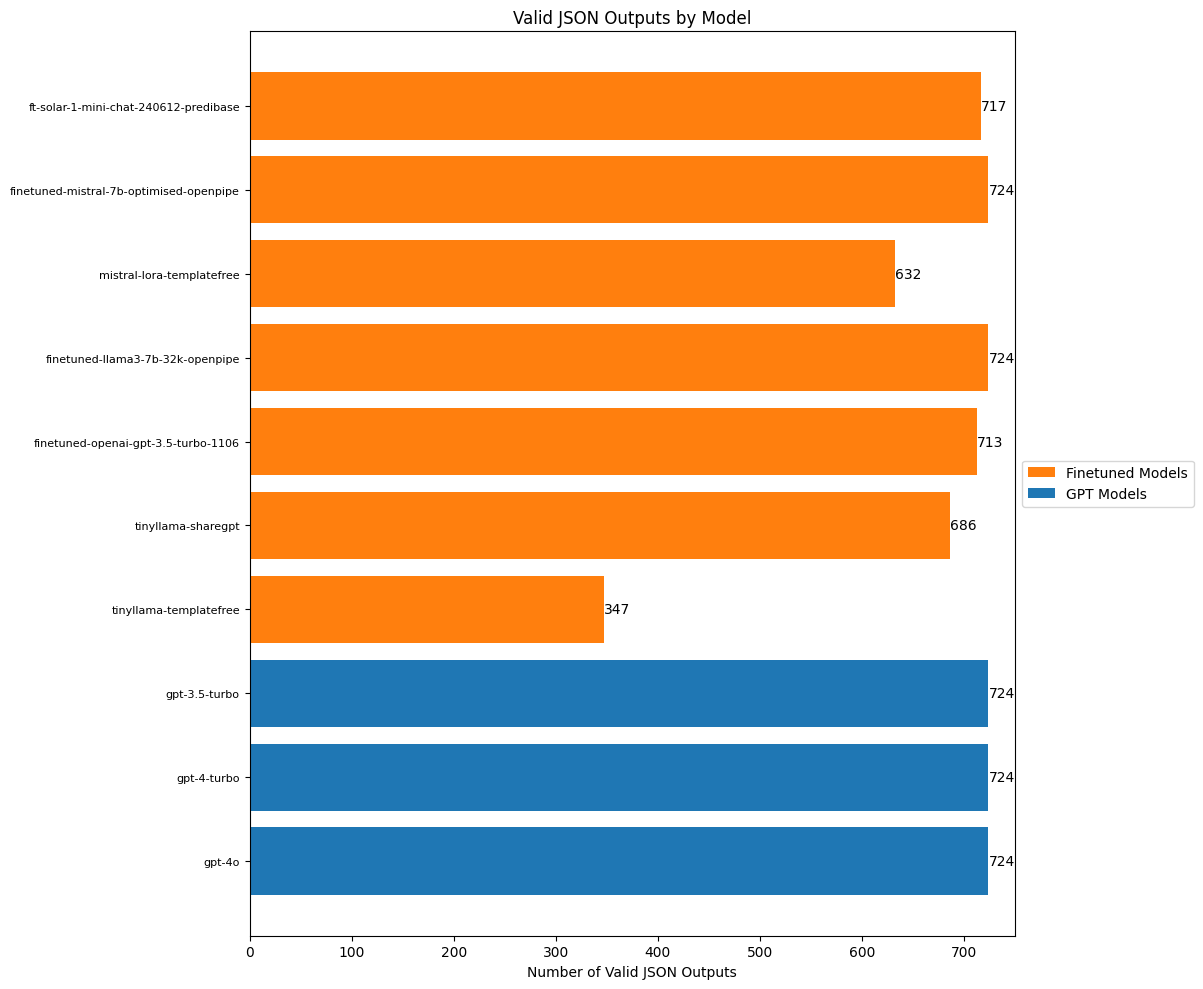

In [30]:
# | code-fold: true
import matplotlib.pyplot as plt
import json

json_aggregate_scores = {
    "gpt-4o": 0,
    "gpt-4-turbo": 0,
    "gpt-3.5-turbo": 0,
    "tinyllama-templatefree": 0,
    "tinyllama-sharegpt": 0,
    "finetuned-openai-gpt-3.5-turbo-1106": 0,
    "finetuned-llama3-7b-32k-openpipe": 0,
    "mistral-lora-templatefree": 0,
    "finetuned-mistral-7b-optimised-openpipe": 0,
    "ft-solar-1-mini-chat-240612-predibase": 0,
}

for row in dataset_with_preds:
    for model in row["predictions"]:
        try:
            json.loads(row["predictions"][model])
            json_aggregate_scores[model] += 1
        except (json.JSONDecodeError, TypeError):
            pass

# print(json_aggregate_scores)

# Separate GPT models and finetuned models
gpt_models = ["gpt-4o", "gpt-4-turbo", "gpt-3.5-turbo"]
finetuned_models = [
    model for model in json_aggregate_scores.keys() if model not in gpt_models
]

# Create lists for plotting
models = list(json_aggregate_scores.keys())
scores = list(json_aggregate_scores.values())
colors = ["#1f77b4" if model in gpt_models else "#ff7f0e" for model in models]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot horizontal bars
bars = ax.barh(models, scores, color=colors)

# Customize the plot
ax.set_xlabel("Number of Valid JSON Outputs")
ax.set_title("Valid JSON Outputs by Model")
ax.set_xlim(0, 750)  # Set x-axis limit to slightly above max score

# Reduce font size for y-axis labels (model names)
ax.tick_params(axis="y", labelsize=8)

# Add value labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    ax.text(
        width, bar.get_y() + bar.get_height() / 2, f"{width}", ha="left", va="center"
    )

# Create custom legend handles
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor="#ff7f0e", label="Finetuned Models"),
    Patch(facecolor="#1f77b4", label="GPT Models"),
]

# Add a legend outside the plot
ax.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1, 0.5))

# Adjust layout to prevent clipping and make room for the legend
plt.tight_layout()
plt.subplots_adjust(right=0.85)

# Show the plot
plt.show()

It's already instructive to see the difference between the templatefree and the
sharegpt template's ability to generate valid JSON for the TinyLlama finetune.
The OpenAI models generate valid JSON every single time, as does the finetuned
Mistral and Llama3 models.

While writing the code to evaluate the models, I noticed that some entries were blank or had no predictions at all, so I
looked into that next.

In [31]:
# find out how many of the predictions are None values or empty strings
missing_values = {
    "gpt-4o": 0,
    "gpt-4-turbo": 0,
    "gpt-3.5-turbo": 0,
    "tinyllama-templatefree": 0,
    "tinyllama-sharegpt": 0,
    "finetuned-openai-gpt-3.5-turbo-1106": 0,
    "finetuned-llama3-7b-32k-openpipe": 0,
    "mistral-lora-templatefree": 0,
    "finetuned-mistral-7b-optimised-openpipe": 0,
    "ft-solar-1-mini-chat-240612-predibase": 0,
}

for row in dataset_with_preds:
    for model in row["predictions"]:
        if row["predictions"][model] is None or row["predictions"][model] == "":
            missing_values[model] += 1

print(missing_values)

{
    'gpt-4o': 0,
    'gpt-4-turbo': 0,
    'gpt-3.5-turbo': 0,
    'tinyllama-templatefree': 0,
    'tinyllama-sharegpt': 38,
    'finetuned-openai-gpt-3.5-turbo-1106': 0,
    'finetuned-llama3-7b-32k-openpipe': 0,
    'mistral-lora-templatefree': 0,
    'finetuned-mistral-7b-optimised-openpipe': 0,
    'ft-solar-1-mini-chat-240612-predibase': 0
}

So were it not for the missing values, the `tinyllama-sharegpt` model would have
had all 724 predictions, and valid JSON as well.

Now we can get into what we're really interested in: accuracy. I'll calculate
scores for all the properties where it makes sense for us to have a score and
then show the results comparing the models.

These are:

- `start_date`
- `province`
- `target_group`
- `event_type`
- `min_killed`
- `min_captured`
- `killq`
- `captureq`
- `killcaptureraid`
- `airstrike`
- `noshotsfired`
- `min_leaders_killed`
- `min_leaders_captured`

Important note, for all these charts that follow, the total number of tasks was
724, so the numbers are out of a total of 724.

# Start Date Accuracy

In [14]:
# | code-fold: true
start_date_scores = {
    "gpt-4o": 0,
    "gpt-4-turbo": 0,
    "gpt-3.5-turbo": 0,
    "tinyllama-templatefree": 0,
    "tinyllama-sharegpt": 0,
    "finetuned-openai-gpt-3.5-turbo-1106": 0,
    "finetuned-llama3-7b-32k-openpipe": 0,
    "mistral-lora-templatefree": 0,
    "finetuned-mistral-7b-optimised-openpipe": 0,
    "ft-solar-1-mini-chat-240612-predibase": 0,
}

for row in dataset_with_preds:
    for model_name, pred in row["predictions"].items():
        if not pred:
            continue
        try:
            pred_dict = json.loads(pred)
            if (
                type(pred_dict) not in (int, float)
                and pred_dict.get("start_date")
                and (pred_dict["start_date"] == row["start_date"].strftime("%Y-%m-%d"))
            ):
                start_date_scores[model_name] += 1
        except json.JSONDecodeError:
            pass

print(start_date_scores)

{
    'gpt-4o': 527,
    'gpt-4-turbo': 522,
    'gpt-3.5-turbo': 492,
    'tinyllama-templatefree': 231,
    'tinyllama-sharegpt': 479,
    'finetuned-openai-gpt-3.5-turbo-1106': 646,
    'finetuned-llama3-7b-32k-openpipe': 585,
    'mistral-lora-templatefree': 0,
    'finetuned-mistral-7b-optimised-openpipe': 636,
    'ft-solar-1-mini-chat-240612-predibase': 649
}

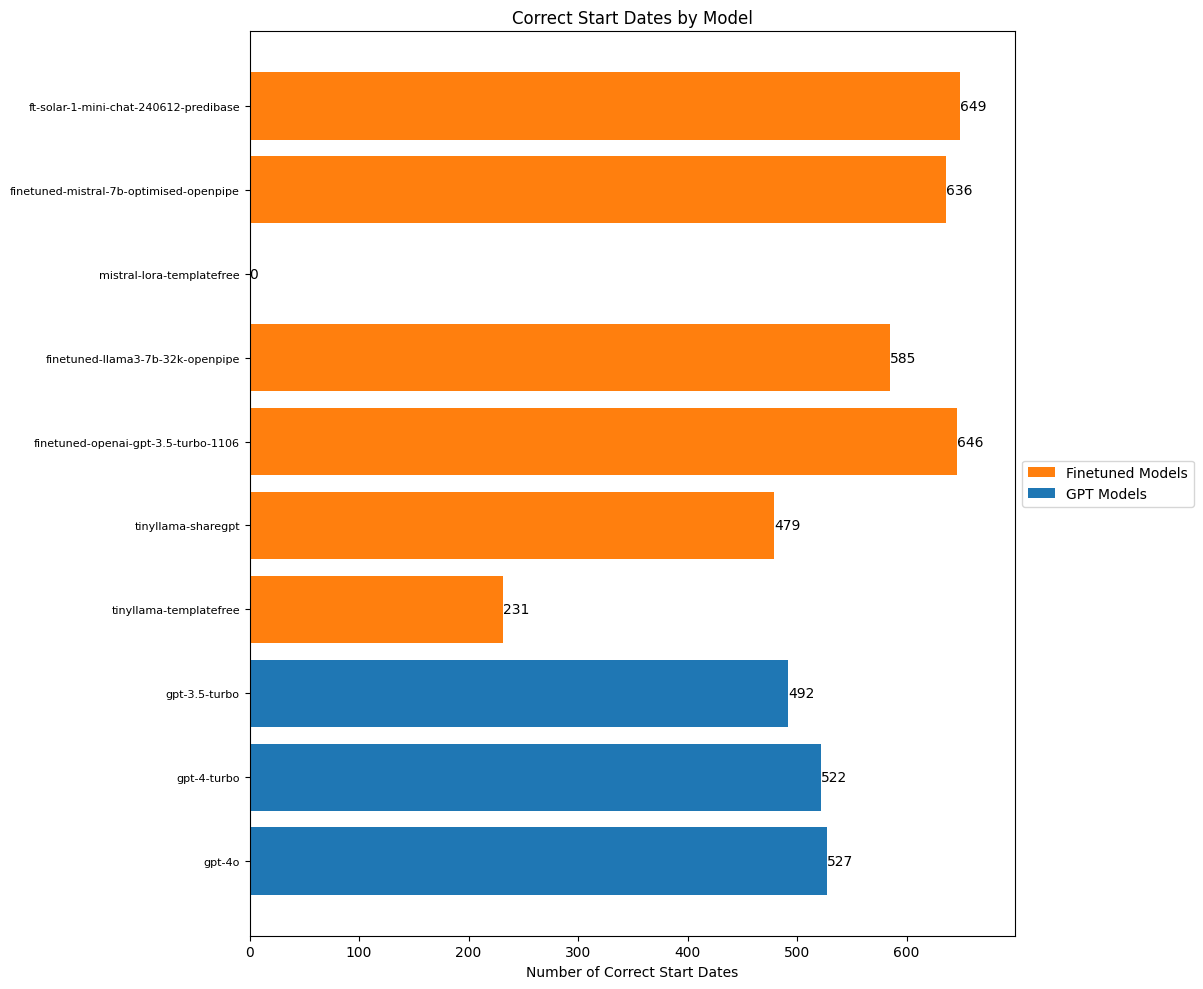

In [15]:
# | code-fold: true
import matplotlib.pyplot as plt

# Separate GPT models and finetuned models
gpt_models = ["gpt-4o", "gpt-4-turbo", "gpt-3.5-turbo"]
finetuned_models = [
    model for model in start_date_scores.keys() if model not in gpt_models
]

# Create lists for plotting
models = list(start_date_scores.keys())
scores = list(start_date_scores.values())
colors = ["#1f77b4" if model in gpt_models else "#ff7f0e" for model in models]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot horizontal bars
bars = ax.barh(models, scores, color=colors)

# Customize the plot
ax.set_xlabel("Number of Correct Start Dates")
ax.set_title("Correct Start Dates by Model")
ax.set_xlim(0, max(scores) + 50)  # Set x-axis limit to slightly above max score

# Reduce font size for y-axis labels (model names)
ax.tick_params(axis="y", labelsize=8)

# Add value labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    ax.text(
        width, bar.get_y() + bar.get_height() / 2, f"{width}", ha="left", va="center"
    )

# Create custom legend handles
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor="#ff7f0e", label="Finetuned Models"),
    Patch(facecolor="#1f77b4", label="GPT Models"),
]

# Add a legend outside the plot
ax.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1, 0.5))

# Adjust layout to prevent clipping and make room for the legend
plt.tight_layout()
plt.subplots_adjust(right=0.85)

# Show the plot
plt.show()

Both Solar and our finetuned GPT3.5 model performed best on predicting which
date the event took place. I'm surprised how poorly the OpenAI models did here,
actually. And even our best model still got 75 of the dates wrong. This feels
like something that I'd want to improve on. Possibly synthetic data could help,
or maybe just an improvement in the finetuning prompt as well.

# Province Accuracy

In [16]:
# | code-fold: true
province_scores = {
    "gpt-4o": 0,
    "gpt-4-turbo": 0,
    "gpt-3.5-turbo": 0,
    "tinyllama-templatefree": 0,
    "tinyllama-sharegpt": 0,
    "finetuned-openai-gpt-3.5-turbo-1106": 0,
    "finetuned-llama3-7b-32k-openpipe": 0,
    "mistral-lora-templatefree": 0,
    "finetuned-mistral-7b-optimised-openpipe": 0,
    "ft-solar-1-mini-chat-240612-predibase": 0,
}

for row in dataset_with_preds:
    for model_name, pred in row["predictions"].items():
        if not pred:
            continue
        try:
            pred_dict = json.loads(pred)
            if isinstance(pred_dict, dict) and "province" in pred_dict:
                pred_provinces = pred_dict["province"]
                if isinstance(pred_provinces, str):
                    pred_provinces = [pred_provinces]
                if set(pred_provinces) == set(row["province"]):
                    province_scores[model_name] += 1
        except (json.JSONDecodeError, KeyError, TypeError):
            pass

print(province_scores)

{
    'gpt-4o': 649,
    'gpt-4-turbo': 645,
    'gpt-3.5-turbo': 595,
    'tinyllama-templatefree': 335,
    'tinyllama-sharegpt': 660,
    'finetuned-openai-gpt-3.5-turbo-1106': 704,
    'finetuned-llama3-7b-32k-openpipe': 707,
    'mistral-lora-templatefree': 0,
    'finetuned-mistral-7b-optimised-openpipe': 711,
    'ft-solar-1-mini-chat-240612-predibase': 704
}

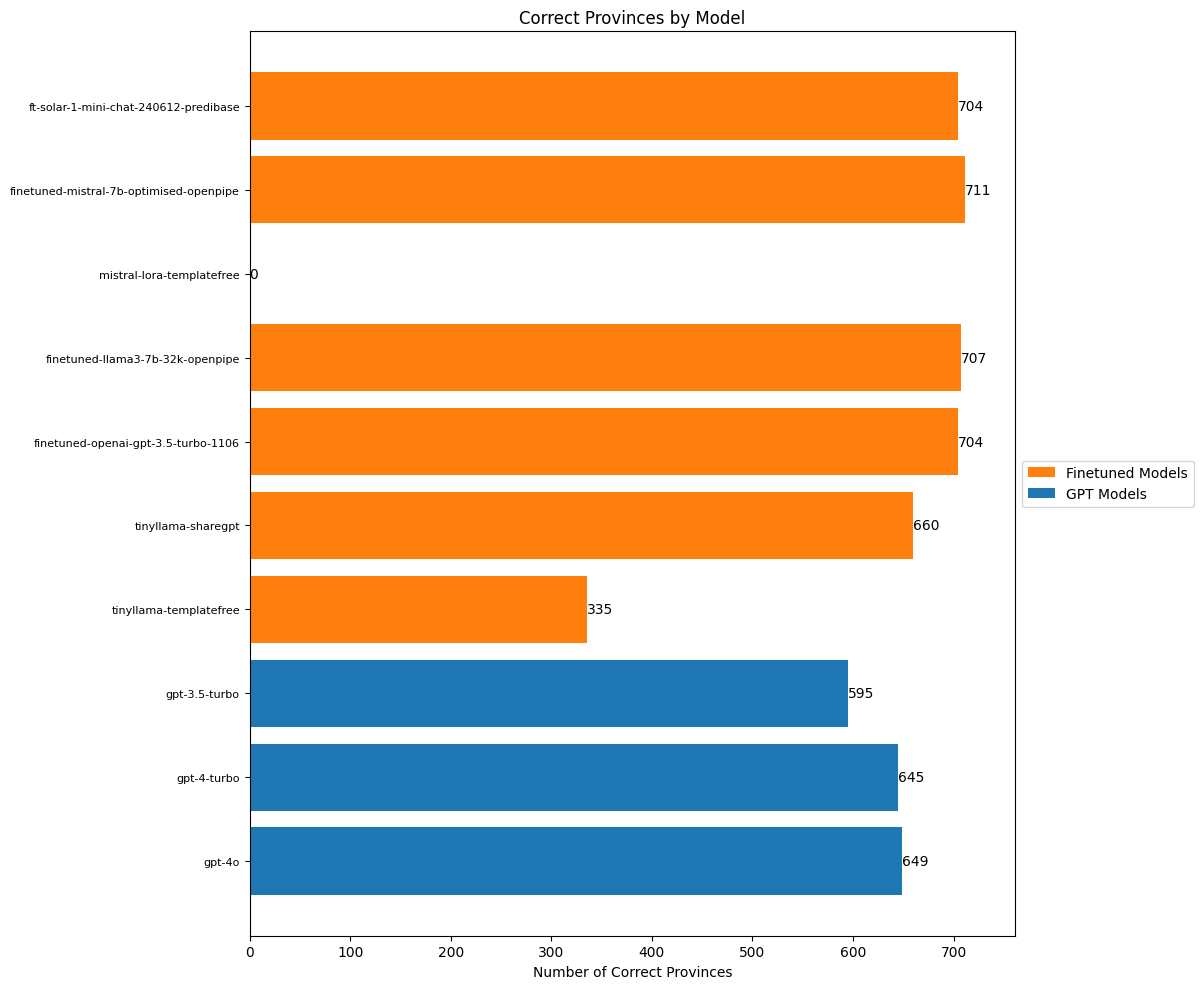

In [17]:
# | code-fold: true
import matplotlib.pyplot as plt

# Separate GPT models and finetuned models
gpt_models = ["gpt-4o", "gpt-4-turbo", "gpt-3.5-turbo"]
finetuned_models = [
    model for model in province_scores.keys() if model not in gpt_models
]

# Create lists for plotting
models = list(province_scores.keys())
scores = list(province_scores.values())
colors = ["#1f77b4" if model in gpt_models else "#ff7f0e" for model in models]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot horizontal bars
bars = ax.barh(models, scores, color=colors)

# Customize the plot
ax.set_xlabel("Number of Correct Provinces")
ax.set_title("Correct Provinces by Model")
ax.set_xlim(0, max(scores) + 50)  # Set x-axis limit to slightly above max score

# Reduce font size for y-axis labels (model names)
ax.tick_params(axis="y", labelsize=8)

# Add value labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    ax.text(
        width, bar.get_y() + bar.get_height() / 2, f"{width}", ha="left", va="center"
    )

# Create custom legend handles
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor="#ff7f0e", label="Finetuned Models"),
    Patch(facecolor="#1f77b4", label="GPT Models"),
]

# Add a legend outside the plot
ax.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1, 0.5))

# Adjust layout to prevent clipping and make room for the legend
plt.tight_layout()
plt.subplots_adjust(right=0.85)

# Show the plot
plt.show()

In what will become a theme, the finetuned models actually outperform the OpenAI
models, only making a few mistakes. Once again I'm surprised how poorly GPT3.5
did on this task.

# Target Group Accuracy

Here there are potentially multiple groups mentioned as target group so I'll
give a score out of 1 of how many of the groups the model predicted were correct.

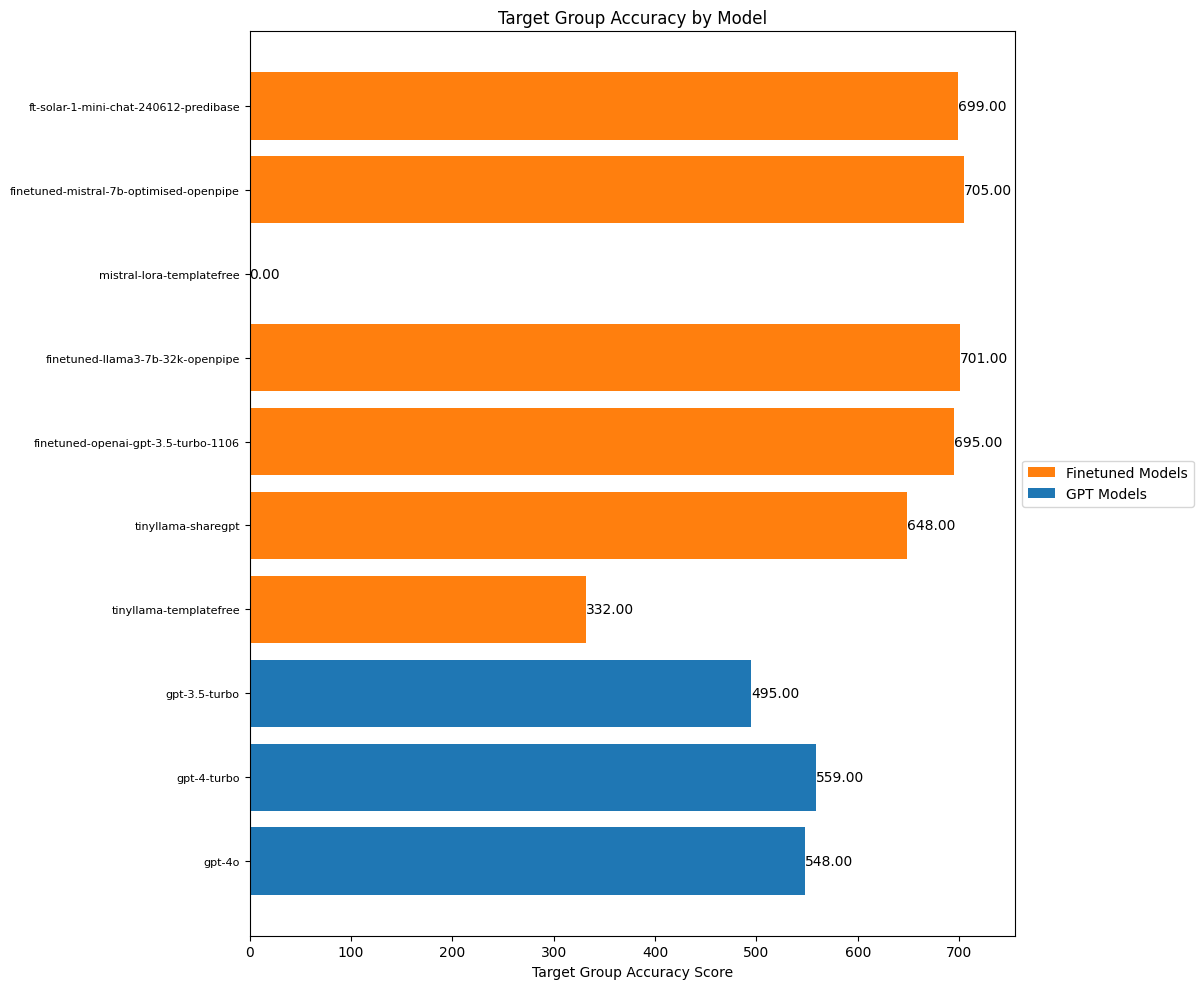

In [32]:
# | code-fold: true
import matplotlib.pyplot as plt

target_group_scores = {
    "gpt-4o": 0,
    "gpt-4-turbo": 0,
    "gpt-3.5-turbo": 0,
    "tinyllama-templatefree": 0,
    "tinyllama-sharegpt": 0,
    "finetuned-openai-gpt-3.5-turbo-1106": 0,
    "finetuned-llama3-7b-32k-openpipe": 0,
    "mistral-lora-templatefree": 0,
    "finetuned-mistral-7b-optimised-openpipe": 0,
    "ft-solar-1-mini-chat-240612-predibase": 0,
}

for row in dataset_with_preds:
    for model_name, pred in row["predictions"].items():
        if not pred:
            continue
        try:
            pred_dict = json.loads(pred)
            if isinstance(pred_dict, dict) and "target_group" in pred_dict:
                pred_groups = pred_dict["target_group"]
                if isinstance(pred_groups, str):
                    pred_groups = [pred_groups]
                correct_groups = row["target_group"]
                if isinstance(correct_groups, str):
                    correct_groups = [correct_groups]
                if correct_groups:
                    score = len(set(pred_groups) & set(correct_groups)) / len(
                        set(correct_groups)
                    )
                    target_group_scores[model_name] += score
        except (json.JSONDecodeError, KeyError, TypeError):
            pass

# Separate GPT models and finetuned models
gpt_models = ["gpt-4o", "gpt-4-turbo", "gpt-3.5-turbo"]
finetuned_models = [
    model for model in target_group_scores.keys() if model not in gpt_models
]

# Create lists for plotting
models = list(target_group_scores.keys())
scores = list(target_group_scores.values())
colors = ["#1f77b4" if model in gpt_models else "#ff7f0e" for model in models]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 10))

# Plot horizontal bars
bars = ax.barh(models, scores, color=colors)

# Customize the plot
ax.set_xlabel("Target Group Accuracy Score")
ax.set_title("Target Group Accuracy by Model")
ax.set_xlim(0, max(scores) + 50)  # Set x-axis limit to slightly above max score

# Reduce font size for y-axis labels (model names)
ax.tick_params(axis="y", labelsize=8)

# Add value labels at the end of each bar
for bar in bars:
    width = bar.get_width()
    ax.text(
        width,
        bar.get_y() + bar.get_height() / 2,
        f"{width:.2f}",
        ha="left",
        va="center",
    )

# Create custom legend handles
from matplotlib.patches import Patch

legend_elements = [
    Patch(facecolor="#ff7f0e", label="Finetuned Models"),
    Patch(facecolor="#1f77b4", label="GPT Models"),
]

# Add a legend outside the plot
ax.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1, 0.5))

# Adjust layout to prevent clipping and make room for the legend
plt.tight_layout()
plt.subplots_adjust(right=0.85)

# Show the plot
plt.show()

Finetuned models doing significantly better than OpenAI for target group
identification. I suspect that this would degrade if we added some new groups
who weren't in the training data (as I'd written about [in my last post](https://mlops.systems/posts/2024-06-25-evaluation-finetuning-manual-dataset.html).)

# Event Type Accuracy

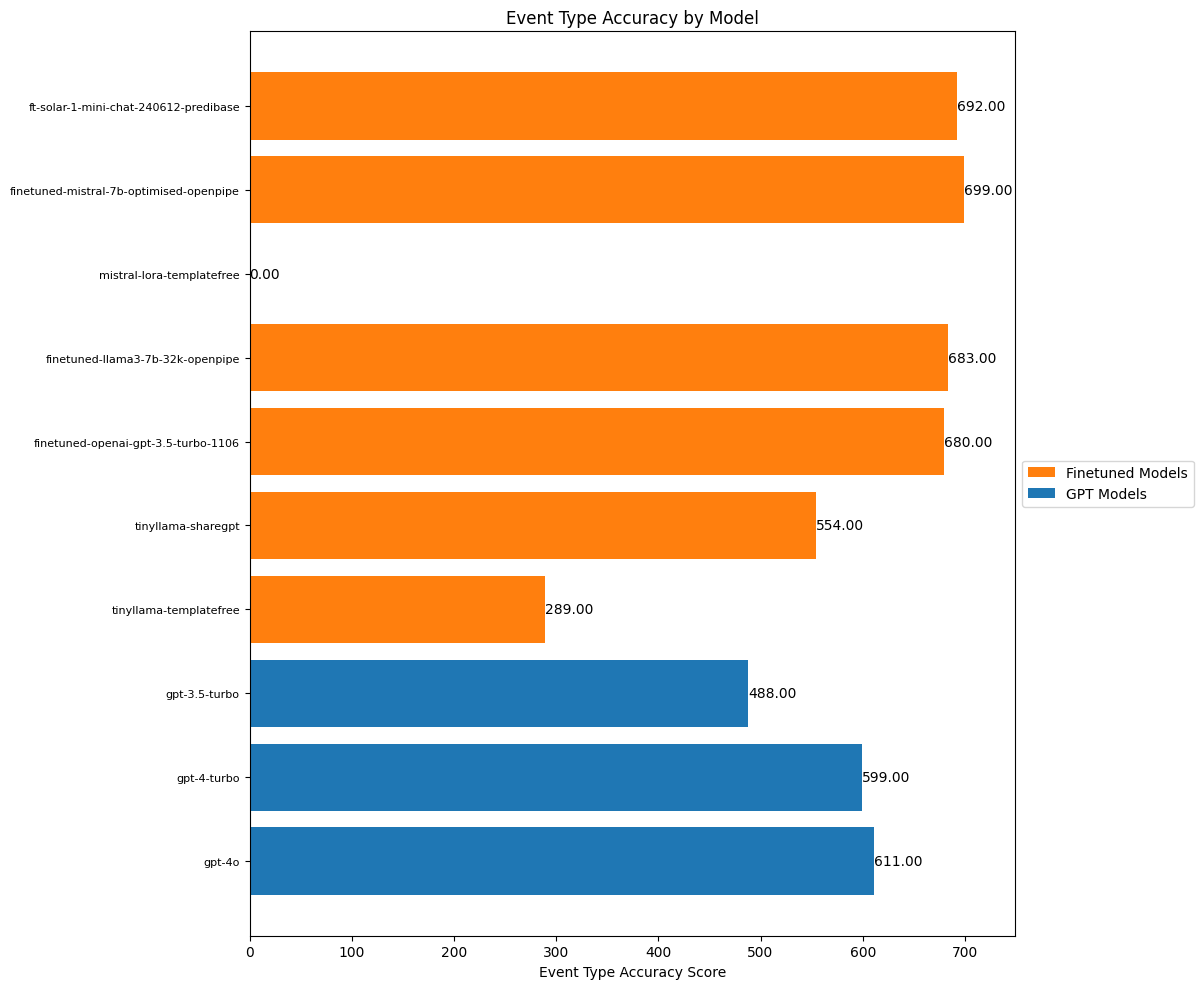

In [19]:
# | code-fold: true
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from typing import Dict, Union


def create_accuracy_chart(
    scores: Dict[str, Union[int, float]], title: str, xlabel: str
) -> None:
    # Separate GPT models and finetuned models
    gpt_models = ["gpt-4o", "gpt-4-turbo", "gpt-3.5-turbo"]
    finetuned_models = [model for model in scores.keys() if model not in gpt_models]

    # Create lists for plotting
    models = list(scores.keys())
    scores_list = list(scores.values())
    colors = ["#1f77b4" if model in gpt_models else "#ff7f0e" for model in models]

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot horizontal bars
    bars = ax.barh(models, scores_list, color=colors)

    # Customize the plot
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.set_xlim(
        0, max(scores_list) + 50
    )  # Set x-axis limit to slightly above max score

    # Reduce font size for y-axis labels (model names)
    ax.tick_params(axis="y", labelsize=8)

    # Add value labels at the end of each bar
    for bar in bars:
        width = bar.get_width()
        ax.text(
            width,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.2f}" if isinstance(width, float) else f"{width}",
            ha="left",
            va="center",
        )

    # Create custom legend handles
    legend_elements = [
        Patch(facecolor="#ff7f0e", label="Finetuned Models"),
        Patch(facecolor="#1f77b4", label="GPT Models"),
    ]

    # Add a legend outside the plot
    ax.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1, 0.5))

    # Adjust layout to prevent clipping and make room for the legend
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)

    # Show the plot
    plt.show()


event_type_scores = {
    "gpt-4o": 0,
    "gpt-4-turbo": 0,
    "gpt-3.5-turbo": 0,
    "tinyllama-templatefree": 0,
    "tinyllama-sharegpt": 0,
    "finetuned-openai-gpt-3.5-turbo-1106": 0,
    "finetuned-llama3-7b-32k-openpipe": 0,
    "mistral-lora-templatefree": 0,
    "finetuned-mistral-7b-optimised-openpipe": 0,
    "ft-solar-1-mini-chat-240612-predibase": 0,
}

for row in dataset_with_preds:
    for model_name, pred in row["predictions"].items():
        if not pred:
            continue
        try:
            pred_dict = json.loads(pred)
            if isinstance(pred_dict, dict) and "event_type" in pred_dict:
                pred_types = pred_dict["event_type"]
                if isinstance(pred_types, str):
                    pred_types = [pred_types]
                correct_types = row["event_type"]
                if isinstance(correct_types, str):
                    correct_types = [correct_types]
                if correct_types:
                    score = len(set(pred_types) & set(correct_types)) / len(
                        set(correct_types)
                    )
                    event_type_scores[model_name] += score
        except (json.JSONDecodeError, KeyError, TypeError):
            pass

create_accuracy_chart(
    scores=event_type_scores,
    title="Event Type Accuracy by Model",
    xlabel="Event Type Accuracy Score",
)

Event type is actually one of the hardest categories since there are actually
some semantically overlapping categories and it's sometimes even hard for a
human annotator, but once again the finetuned models do pretty well.

# Accuracy for `min_killed`

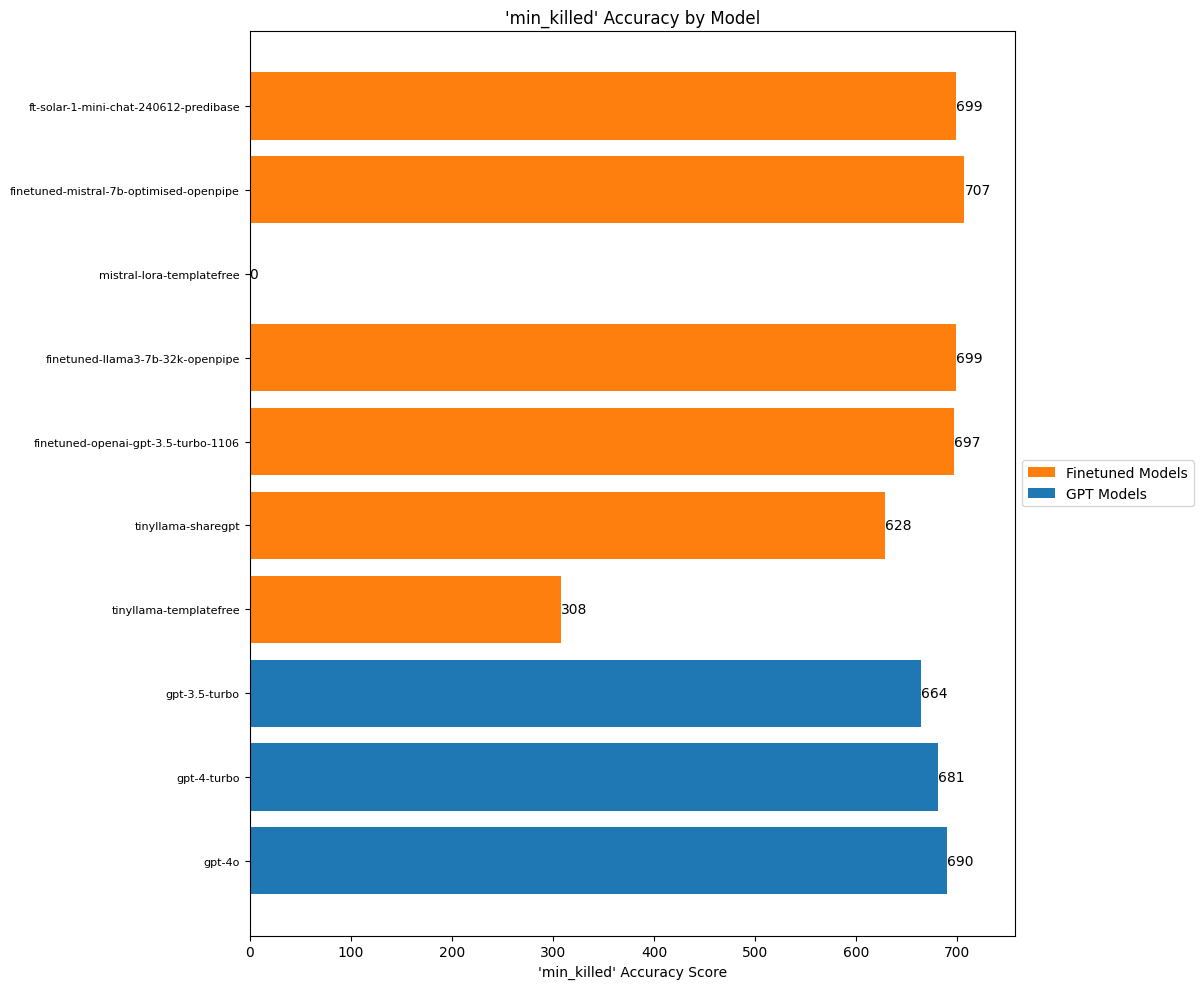

In [20]:
# | code-fold: true
import json

min_killed_scores = {
    "gpt-4o": 0,
    "gpt-4-turbo": 0,
    "gpt-3.5-turbo": 0,
    "tinyllama-templatefree": 0,
    "tinyllama-sharegpt": 0,
    "finetuned-openai-gpt-3.5-turbo-1106": 0,
    "finetuned-llama3-7b-32k-openpipe": 0,
    "mistral-lora-templatefree": 0,
    "finetuned-mistral-7b-optimised-openpipe": 0,
    "ft-solar-1-mini-chat-240612-predibase": 0,
}

for row in dataset_with_preds:
    for model_name, pred in row["predictions"].items():
        if not pred:
            continue
        try:
            pred_dict = json.loads(pred)
            if isinstance(pred_dict, dict) and "min_killed" in pred_dict:
                pred_min_killed = pred_dict["min_killed"]
                correct_min_killed = row["min_killed"]
                if pred_min_killed == correct_min_killed:
                    min_killed_scores[model_name] += 1
        except (json.JSONDecodeError, KeyError, TypeError):
            pass

create_accuracy_chart(
    scores=min_killed_scores,
    title="'min_killed' Accuracy by Model",
    xlabel="'min_killed' Accuracy Score"
)

For these number estimations, suddenly the playing fields gets leveled between
the finetuned and the OpenAI models. Mistral still comes out on top, but not by
much! And it's impressive how the OpenAI models do really well at this. I
suspect this is because of the whole section in the prompt which explained the
rubric that was used for annotating the examples:

> Annotation notes: A 'faciliator' is not a leader. If a press release states that 'insurgents' were detained without further details, assign a minimum number of two detained. Interpret 'a couple' as two. Interpret 'several' as at least three, even though it may sometimes refer to seven or eight. Classify the terms 'a few', 'some', 'a group', 'a small group', and 'multiple' as denoting at least three, even if they sometimes refer to larger numbers. Choose the smaller number if no other information is available in the press release to come up with a minimally acceptable figure. Interpret 'numerous' and 'a handful' as at least four, and 'a large number' as at least five.


# Accuracy for `min_captured`

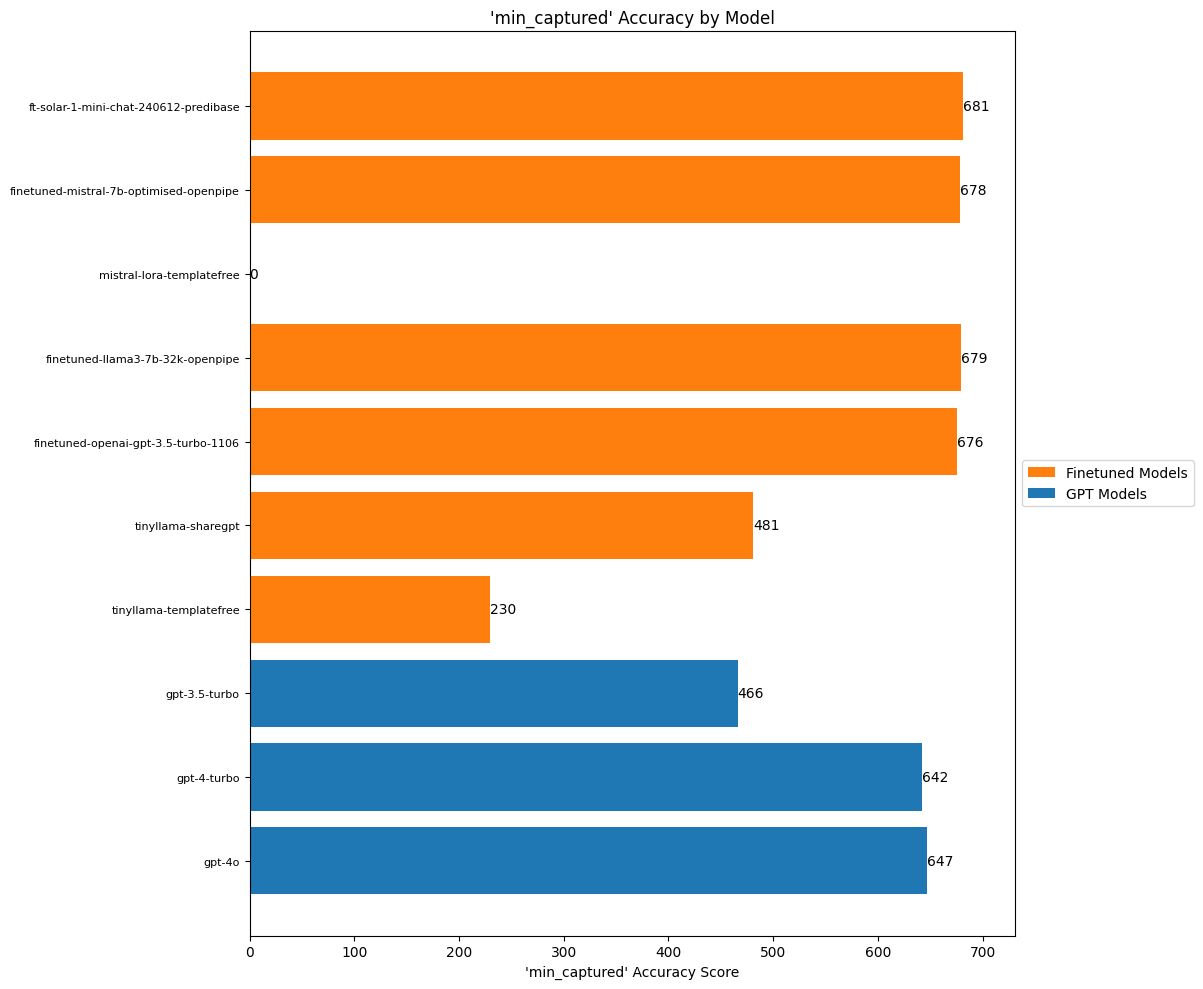

In [21]:
# | code-fold: true
import json

min_captured_scores = {
    "gpt-4o": 0,
    "gpt-4-turbo": 0,
    "gpt-3.5-turbo": 0,
    "tinyllama-templatefree": 0,
    "tinyllama-sharegpt": 0,
    "finetuned-openai-gpt-3.5-turbo-1106": 0,
    "finetuned-llama3-7b-32k-openpipe": 0,
    "mistral-lora-templatefree": 0,
    "finetuned-mistral-7b-optimised-openpipe": 0,
    "ft-solar-1-mini-chat-240612-predibase": 0,
}

for row in dataset_with_preds:
    for model_name, pred in row["predictions"].items():
        if not pred:
            continue
        try:
            pred_dict = json.loads(pred)
            if isinstance(pred_dict, dict) and "min_captured" in pred_dict:
                pred_min_captured = pred_dict["min_captured"]
                correct_min_captured = row["min_captured"]
                if pred_min_captured == correct_min_captured:
                    min_captured_scores[model_name] += 1
        except (json.JSONDecodeError, KeyError, TypeError):
            pass

create_accuracy_chart(
    scores=min_captured_scores,
    title="'min_captured' Accuracy by Model",
    xlabel="'min_captured' Accuracy Score"
)

# Accuracy for `killq`

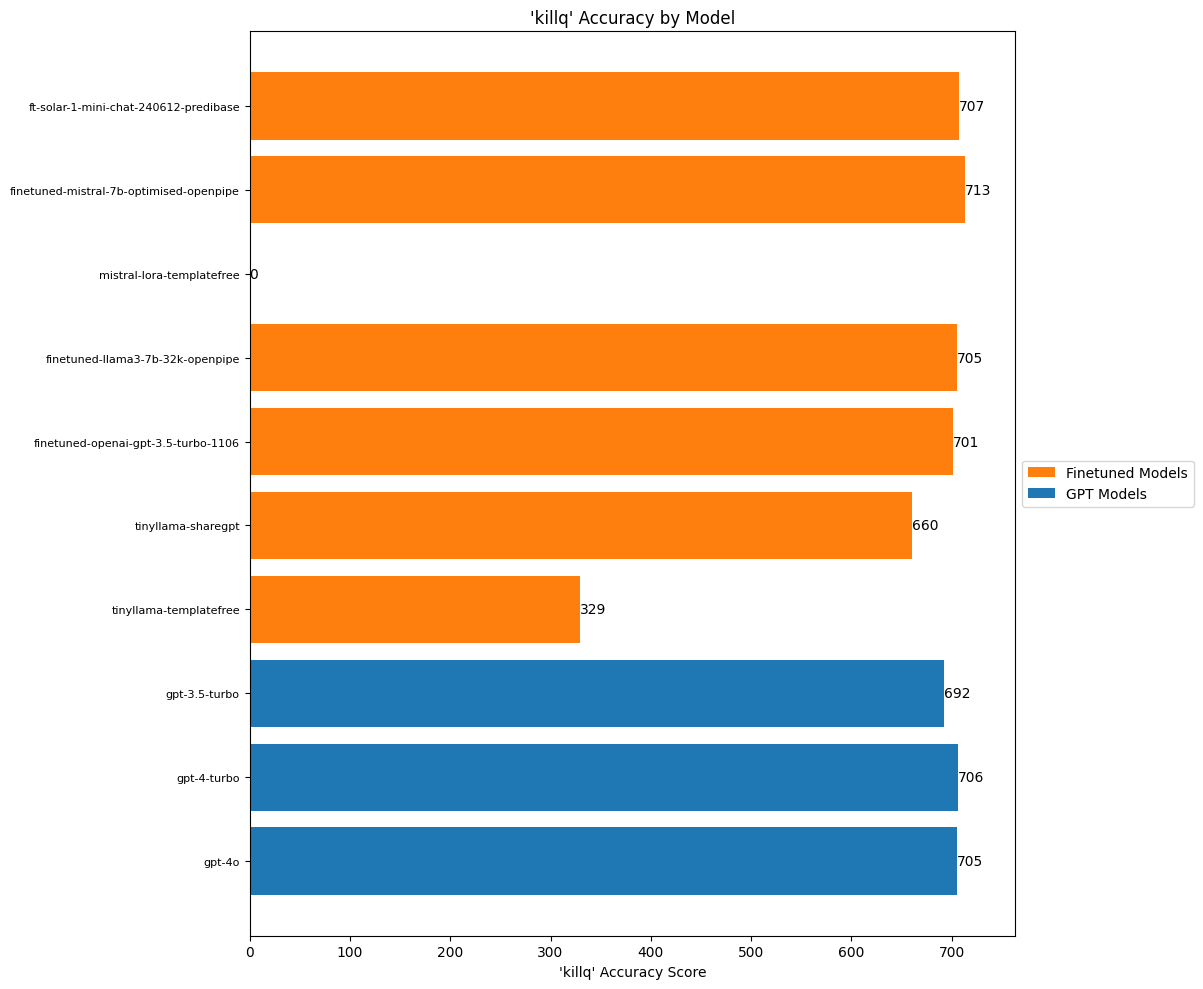

In [22]:
# | code-fold: true
import json

killq_scores = {
    "gpt-4o": 0,
    "gpt-4-turbo": 0,
    "gpt-3.5-turbo": 0,
    "tinyllama-templatefree": 0,
    "tinyllama-sharegpt": 0,
    "finetuned-openai-gpt-3.5-turbo-1106": 0,
    "finetuned-llama3-7b-32k-openpipe": 0,
    "mistral-lora-templatefree": 0,
    "finetuned-mistral-7b-optimised-openpipe": 0,
    "ft-solar-1-mini-chat-240612-predibase": 0,
}

for row in dataset_with_preds:
    for model_name, pred in row["predictions"].items():
        if not pred:
            continue
        try:
            pred_dict = json.loads(pred)
            if isinstance(pred_dict, dict) and "killq" in pred_dict:
                pred_killq = pred_dict["killq"]
                correct_killq = row["killq"]
                if pred_killq == correct_killq:
                    killq_scores[model_name] += 1
        except (json.JSONDecodeError, KeyError, TypeError):
            pass

create_accuracy_chart(
    scores=killq_scores,
    title="'killq' Accuracy by Model",
    xlabel="'killq' Accuracy Score"
)


I'd expect really high accuracy for these boolean attributes, and basically
almost all the models were able to give this. Still, our finetuned Mistral still beats out
GPT-4o best score.

# Accuracy for `captureq`

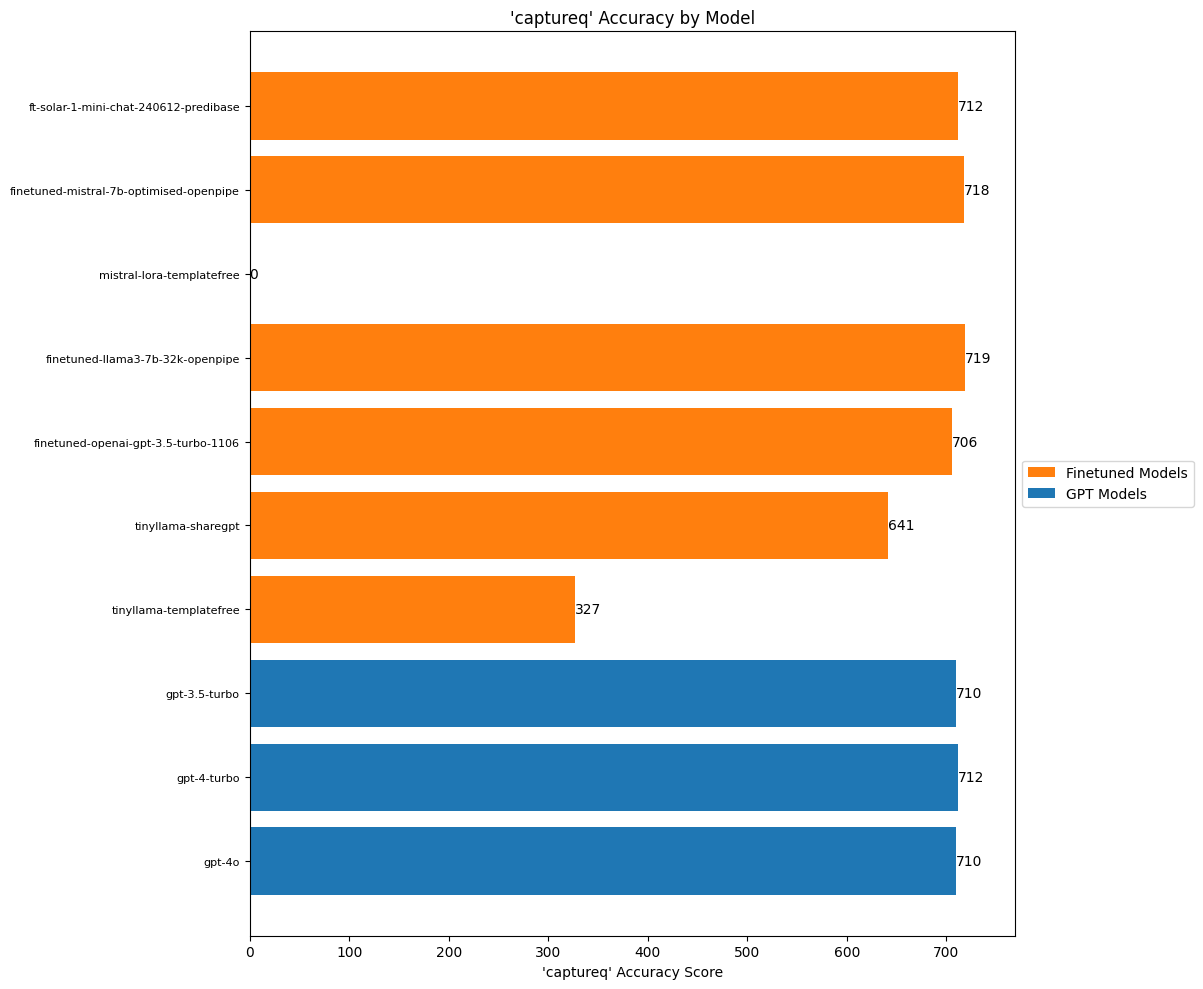

In [23]:
# | code-fold: true
import json

captureq_scores = {
    "gpt-4o": 0,
    "gpt-4-turbo": 0,
    "gpt-3.5-turbo": 0,
    "tinyllama-templatefree": 0,
    "tinyllama-sharegpt": 0,
    "finetuned-openai-gpt-3.5-turbo-1106": 0,
    "finetuned-llama3-7b-32k-openpipe": 0,
    "mistral-lora-templatefree": 0,
    "finetuned-mistral-7b-optimised-openpipe": 0,
    "ft-solar-1-mini-chat-240612-predibase": 0,
}

for row in dataset_with_preds:
    for model_name, pred in row["predictions"].items():
        if not pred:
            continue
        try:
            pred_dict = json.loads(pred)
            if isinstance(pred_dict, dict) and "captureq" in pred_dict:
                pred_captureq = pred_dict["captureq"]
                correct_captureq = row["captureq"]
                if pred_captureq == correct_captureq:
                    captureq_scores[model_name] += 1
        except (json.JSONDecodeError, KeyError, TypeError):
            pass

create_accuracy_chart(
    scores=captureq_scores,
    title="'captureq' Accuracy by Model",
    xlabel="'captureq' Accuracy Score"
)


# Accuracy for `killcaptureraid`

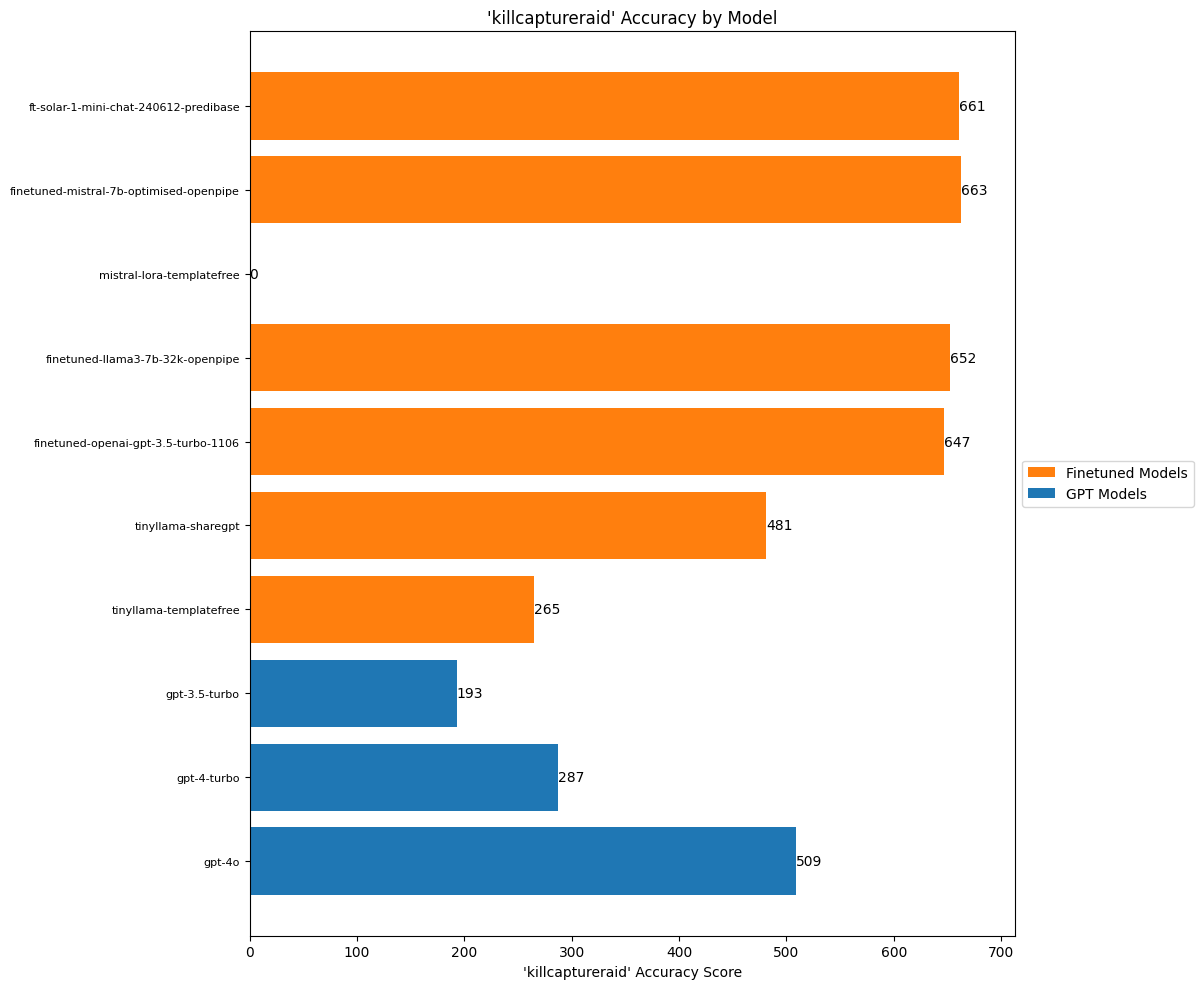

In [24]:
# | code-fold: true
import json

killcaptureraid_scores = {
    "gpt-4o": 0,
    "gpt-4-turbo": 0,
    "gpt-3.5-turbo": 0,
    "tinyllama-templatefree": 0,
    "tinyllama-sharegpt": 0,
    "finetuned-openai-gpt-3.5-turbo-1106": 0,
    "finetuned-llama3-7b-32k-openpipe": 0,
    "mistral-lora-templatefree": 0,
    "finetuned-mistral-7b-optimised-openpipe": 0,
    "ft-solar-1-mini-chat-240612-predibase": 0,
}

for row in dataset_with_preds:
    for model_name, pred in row["predictions"].items():
        if not pred:
            continue
        try:
            pred_dict = json.loads(pred)
            if isinstance(pred_dict, dict) and "killcaptureraid" in pred_dict:
                pred_killcaptureraid = pred_dict["killcaptureraid"]
                correct_killcaptureraid = row["killcaptureraid"]
                if pred_killcaptureraid == correct_killcaptureraid:
                    killcaptureraid_scores[model_name] += 1
        except (json.JSONDecodeError, KeyError, TypeError):
            pass

create_accuracy_chart(
    scores=killcaptureraid_scores,
    title="'killcaptureraid' Accuracy by Model",
    xlabel="'killcaptureraid' Accuracy Score"
)


This is another attribute where it's clear the lack of signposting in the
prompts to the OpenAI models put them at a disadvantage. The term 'kill-capture
raid' is a term of art and it was used in a specific way for the labelling.
OpenAI knows nothing about how I made those calls, which explains why they
performed so poorly here.

# Accuracy for `airstrike`

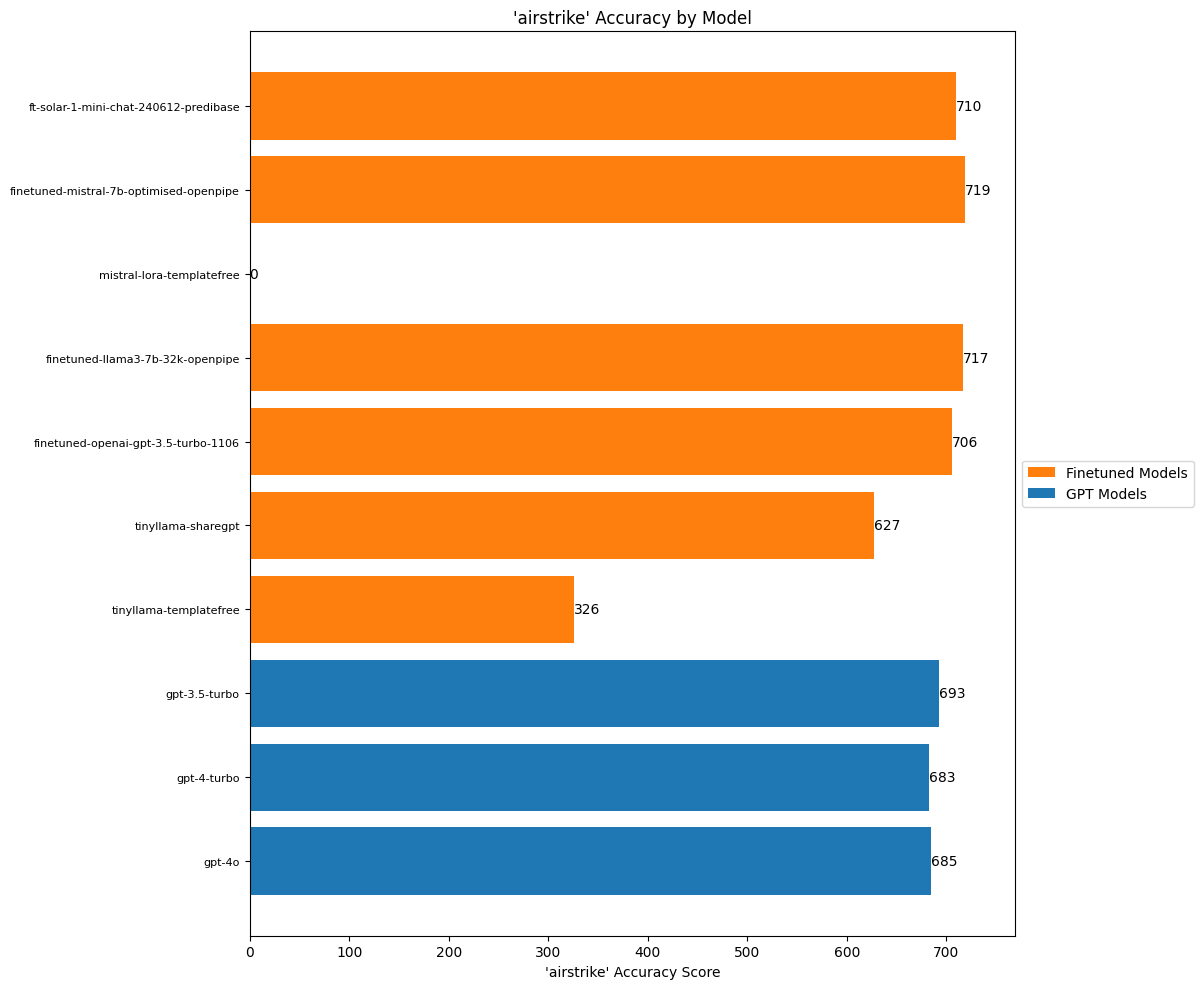

In [25]:
# | code-fold: true
import json

airstrike_scores = {
    "gpt-4o": 0,
    "gpt-4-turbo": 0,
    "gpt-3.5-turbo": 0,
    "tinyllama-templatefree": 0,
    "tinyllama-sharegpt": 0,
    "finetuned-openai-gpt-3.5-turbo-1106": 0,
    "finetuned-llama3-7b-32k-openpipe": 0,
    "mistral-lora-templatefree": 0,
    "finetuned-mistral-7b-optimised-openpipe": 0,
    "ft-solar-1-mini-chat-240612-predibase": 0,
}

for row in dataset_with_preds:
    for model_name, pred in row["predictions"].items():
        if not pred:
            continue
        try:
            pred_dict = json.loads(pred)
            if isinstance(pred_dict, dict) and "airstrike" in pred_dict:
                pred_airstrike = pred_dict["airstrike"]
                correct_airstrike = row["airstrike"]
                if pred_airstrike == correct_airstrike:
                    airstrike_scores[model_name] += 1
        except (json.JSONDecodeError, KeyError, TypeError):
            pass

create_accuracy_chart(
    scores=airstrike_scores,
    title="'airstrike' Accuracy by Model",
    xlabel="'airstrike' Accuracy Score"
)


# Accuracy for `noshotsfired`

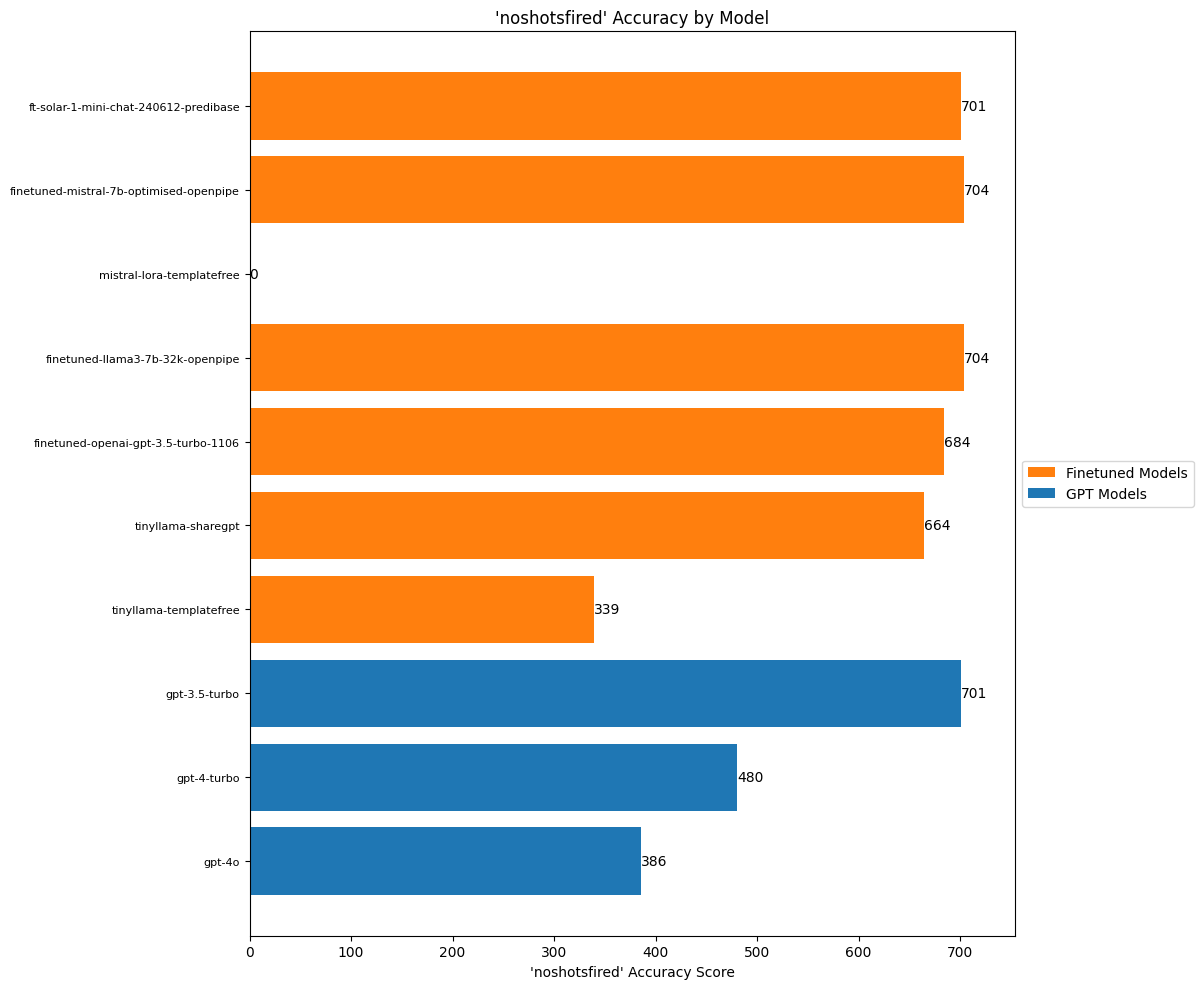

In [26]:
# | code-fold: true
import json

noshotsfired_scores = {
    "gpt-4o": 0,
    "gpt-4-turbo": 0,
    "gpt-3.5-turbo": 0,
    "tinyllama-templatefree": 0,
    "tinyllama-sharegpt": 0,
    "finetuned-openai-gpt-3.5-turbo-1106": 0,
    "finetuned-llama3-7b-32k-openpipe": 0,
    "mistral-lora-templatefree": 0,
    "finetuned-mistral-7b-optimised-openpipe": 0,
    "ft-solar-1-mini-chat-240612-predibase": 0,
}

for row in dataset_with_preds:
    for model_name, pred in row["predictions"].items():
        if not pred:
            continue
        try:
            pred_dict = json.loads(pred)
            if isinstance(pred_dict, dict) and "noshotsfired" in pred_dict:
                pred_noshotsfired = pred_dict["noshotsfired"]
                correct_noshotsfired = row["noshotsfired"]
                if pred_noshotsfired == correct_noshotsfired:
                    noshotsfired_scores[model_name] += 1
        except (json.JSONDecodeError, KeyError, TypeError):
            pass

create_accuracy_chart(
    scores=noshotsfired_scores,
    title="'noshotsfired' Accuracy by Model",
    xlabel="'noshotsfired' Accuracy Score"
)


I'm not quite sure why the OpenAI models are performing in the reverse order of
what you'd expect. Recall that the `noshotsfired` attribute refers to whether
the press release states that no shots were fired during a particular raid /
event. (For a certain period the press releases were keen to mention this and it
was a metric that was particularly useful for ISAF as a public relations
gimmick.)

I can think of some semi-anthropomorphizing ways to explain this around how the
GPT-4 class of models were 'overthinking' the label, but more investigation
would be needed to really understand this.

# Accuracy for `min_leaders_killed`

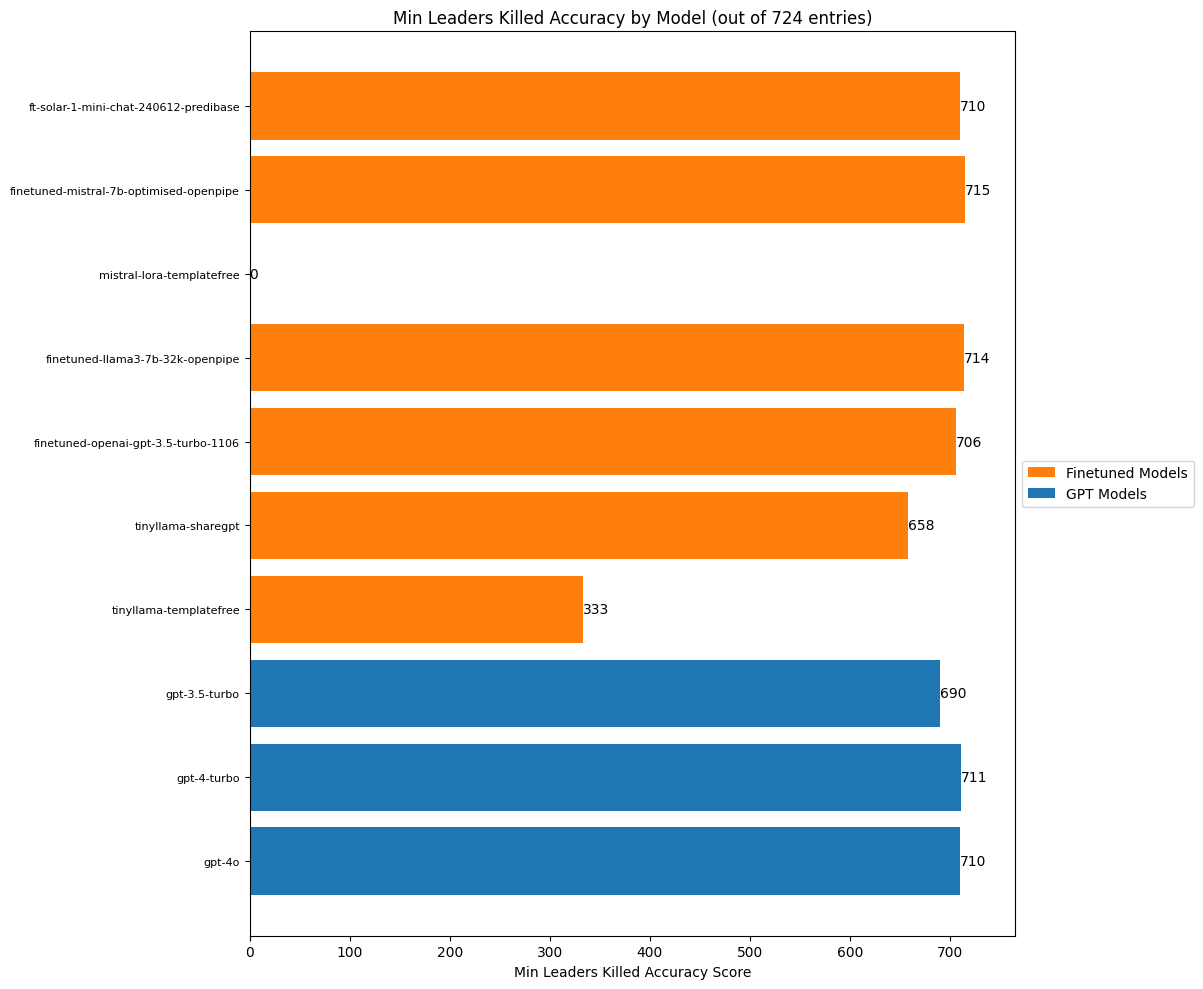

In [27]:
# | code-fold: true
import json

min_leaders_killed_scores = {
    "gpt-4o": 0,
    "gpt-4-turbo": 0,
    "gpt-3.5-turbo": 0,
    "tinyllama-templatefree": 0,
    "tinyllama-sharegpt": 0,
    "finetuned-openai-gpt-3.5-turbo-1106": 0,
    "finetuned-llama3-7b-32k-openpipe": 0,
    "mistral-lora-templatefree": 0,
    "finetuned-mistral-7b-optimised-openpipe": 0,
    "ft-solar-1-mini-chat-240612-predibase": 0,
}

for row in dataset_with_preds:
    for model_name, pred in row["predictions"].items():
        if not pred:
            continue
        try:
            pred_dict = json.loads(pred)
            if isinstance(pred_dict, dict) and "min_leaders_killed" in pred_dict:
                pred_min_leaders_killed = pred_dict["min_leaders_killed"]
                correct_min_leaders_killed = row["min_leaders_killed"]
                if isinstance(pred_min_leaders_killed, int) and isinstance(correct_min_leaders_killed, int):
                    if pred_min_leaders_killed == correct_min_leaders_killed:
                        min_leaders_killed_scores[model_name] += 1
        except (json.JSONDecodeError, KeyError, TypeError):
            pass

total_entries = len(dataset_with_preds)

create_accuracy_chart(
    scores=min_leaders_killed_scores,
    title=f"Min Leaders Killed Accuracy by Model (out of {total_entries} entries)",
    xlabel="Min Leaders Killed Accuracy Score"
)

We often hear about how LLMs are bad with numbers, how they [default to certain
values](https://gramener.com/llmrandom/) and so on, so I was surprised to see
such high scores across the board for this task. I imagine this is something
that everyone has been trying to improve and it shows. Still, though, our
finetuned models do best.

# Accuracy for `min_leaders_captured`

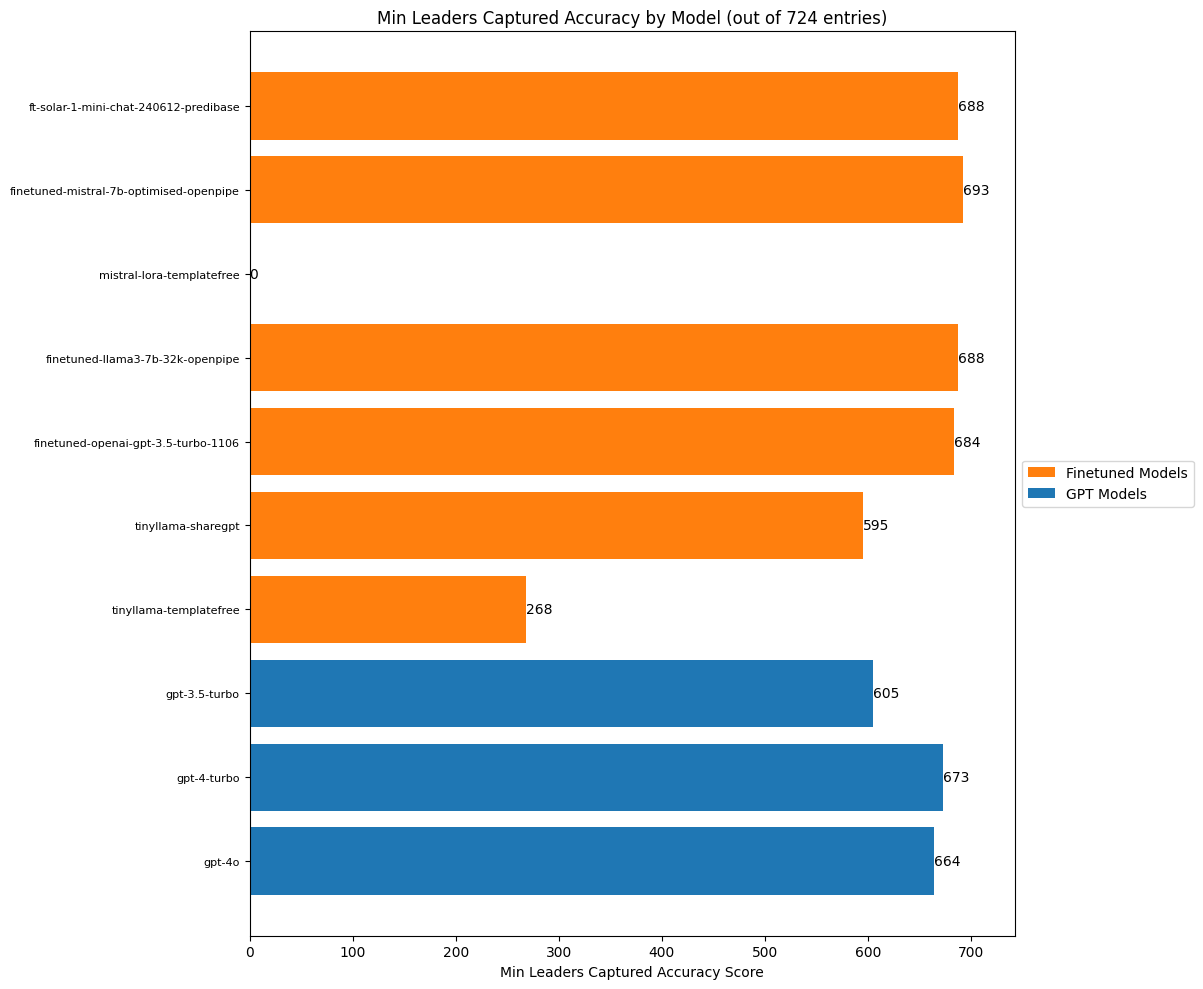

In [28]:
# | code-fold: true
import json

min_leaders_captured_scores = {
    "gpt-4o": 0,
    "gpt-4-turbo": 0,
    "gpt-3.5-turbo": 0,
    "tinyllama-templatefree": 0,
    "tinyllama-sharegpt": 0,
    "finetuned-openai-gpt-3.5-turbo-1106": 0,
    "finetuned-llama3-7b-32k-openpipe": 0,
    "mistral-lora-templatefree": 0,
    "finetuned-mistral-7b-optimised-openpipe": 0,
    "ft-solar-1-mini-chat-240612-predibase": 0,
}

for row in dataset_with_preds:
    for model_name, pred in row["predictions"].items():
        if not pred:
            continue
        try:
            pred_dict = json.loads(pred)
            if isinstance(pred_dict, dict) and "min_leaders_captured" in pred_dict:
                pred_min_leaders_captured = pred_dict["min_leaders_captured"]
                correct_min_leaders_captured = row["min_leaders_captured"]
                if isinstance(pred_min_leaders_captured, int) and isinstance(correct_min_leaders_captured, int):
                    if pred_min_leaders_captured == correct_min_leaders_captured:
                        min_leaders_captured_scores[model_name] += 1
        except (json.JSONDecodeError, KeyError, TypeError):
            pass

total_entries = len(dataset_with_preds)

create_accuracy_chart(
    scores=min_leaders_captured_scores,
    title=f"Min Leaders Captured Accuracy by Model (out of {total_entries} entries)",
    xlabel="Min Leaders Captured Accuracy Score"
)


# Final aggregate scores for the models

Let's add all these individual competency scores up, average them out and get
final scores for how well our models do on accuracy.

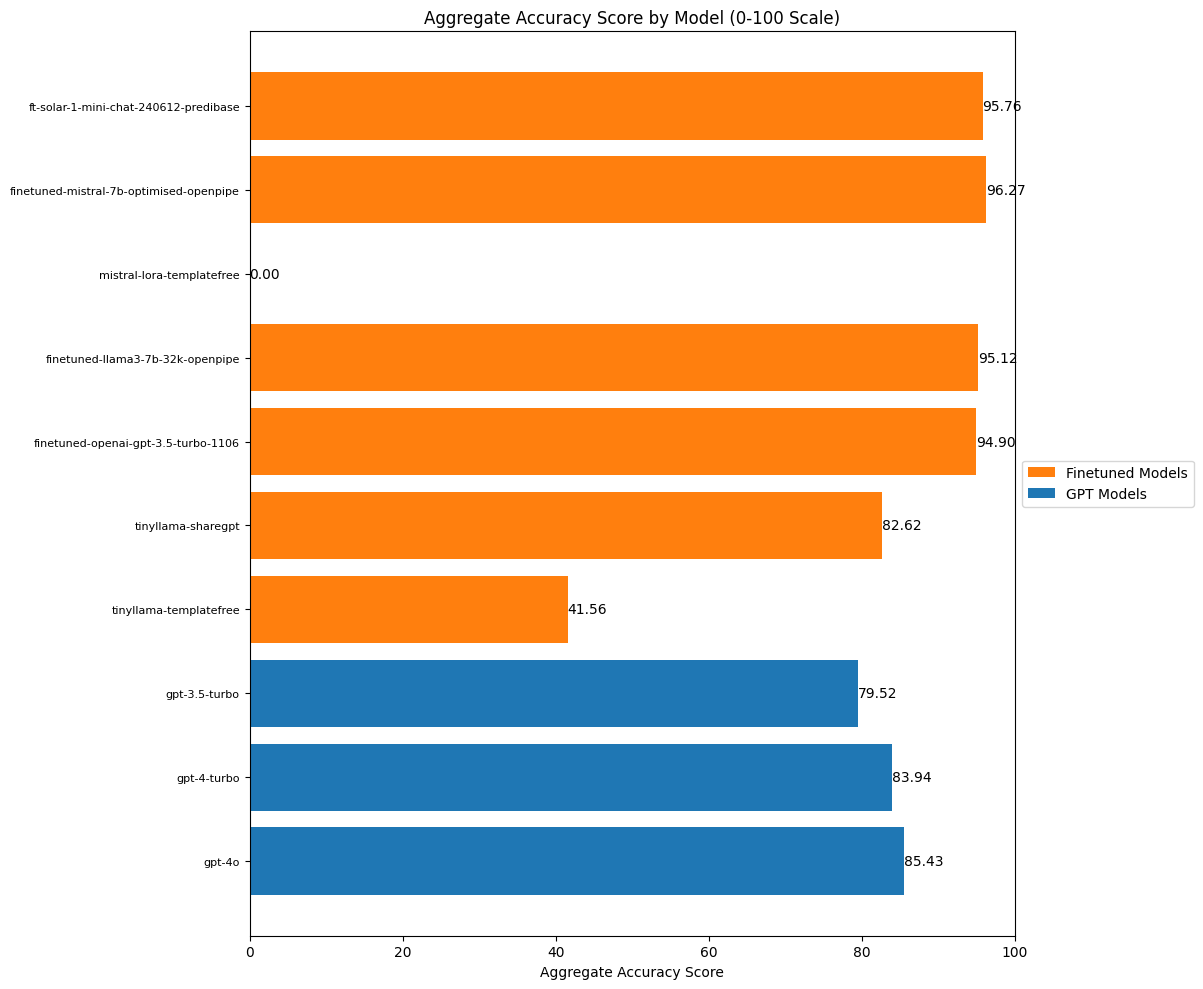

In [29]:
# | code-fold: true
# adapt the function slightly
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from typing import Dict, Union


def create_aggregate_accuracy_chart(
    scores: Dict[str, Union[int, float]], title: str, xlabel: str
) -> None:
    # Separate GPT models and finetuned models
    gpt_models = ["gpt-4o", "gpt-4-turbo", "gpt-3.5-turbo"]
    finetuned_models = [model for model in scores.keys() if model not in gpt_models]

    # Create lists for plotting
    models = list(scores.keys())
    scores_list = list(scores.values())
    colors = ["#1f77b4" if model in gpt_models else "#ff7f0e" for model in models]

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot horizontal bars
    bars = ax.barh(models, scores_list, color=colors)

    # Customize the plot
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    ax.set_xlim(0, 100)  # Set x-axis limit to 100

    # Reduce font size for y-axis labels (model names)
    ax.tick_params(axis="y", labelsize=8)

    # Add value labels at the end of each bar
    for bar in bars:
        width = bar.get_width()
        ax.text(
            width,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.2f}" if isinstance(width, float) else f"{width}",
            ha="left",
            va="center",
        )

    # Create custom legend handles
    legend_elements = [
        Patch(facecolor="#ff7f0e", label="Finetuned Models"),
        Patch(facecolor="#1f77b4", label="GPT Models"),
    ]

    # Add a legend outside the plot
    ax.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(1, 0.5))

    # Adjust layout to prevent clipping and make room for the legend
    plt.tight_layout()
    plt.subplots_adjust(right=0.85)

    # Show the plot
    plt.show()

# List of all the score dictionaries
score_dicts = [
    start_date_scores,
    province_scores,
    target_group_scores,
    event_type_scores,
    min_killed_scores,
    min_captured_scores,
    killq_scores,
    captureq_scores,
    killcaptureraid_scores,
    airstrike_scores,
    noshotsfired_scores,
    min_leaders_killed_scores,
    min_leaders_captured_scores,
]

# Get the list of models
models = list(start_date_scores.keys())

# Initialize the aggregate scores dictionary
aggregate_scores = {model: 0 for model in models}

# Calculate the aggregate score for each model
for model in models:
    total_score = 0
    for score_dict in score_dicts:
        total_score += score_dict[model]
    aggregate_scores[model] = (total_score / len(score_dicts)) / len(dataset_with_preds) * 100

# Create the aggregate score chart
create_aggregate_accuracy_chart(
    scores=aggregate_scores,
    title="Aggregate Accuracy Score by Model (0-100 Scale)",
    xlabel="Aggregate Accuracy Score",
)

Surprising even me, the finetuned models beat out the GPT-class models from
OpenAI. Actually even TinyLlama beats out GPT 3.5 Turbo!

Our top performer was Mistral-7B (finetuned on OpenPipe), very closely followed
by Solar LLM and Llama3-7B. Just looking at the scores above it seems like
anyone finetuning models for structured data extraction would do well to
start of with Mistral-7B, Solar 7B or Llama3-7B and then see which performs
best, though with the caveat that they might all be more or less the same for
accuracy. There are probably different tradeoffs when it comes to serving the
model and the efficiency and latency there, but still these three do really
well.

I think if I were to stuff a few more examples into the prompt (as well a bit
more explanation and rules) I could get the OpenAI models to perform even
better, but at a certain point you have to remember all the things that having
your own finetuned model brings you:

- data privacy (by not sending your confidential information to OpenAI)
- smaller models most likely means better performance (though I still have to
  test and prove that out)
- more control overall
- cost improvements

On the cost, it's a bit hard to make that comparison or claim right now, especially given the economies of scale that the large cloud providers can rely on, but in a real-world use case where you were building this model for repeated inference over a long-term time frame, then you would have a better chance of having the cost argument make sense, particularly since the only way to make the OpenAI inference calls better to stuff them full of examples and extra explanation, significantly bloating the cost-per-query.

That said, there are some real tradeoffs that come up when finetuning a model,
and I'll get to some of those in my concluding thoughts.

# Finetuning works a charm, but...

First off I'm so pleased that the oft-repeated "finetune your model and get
better performance than with GPT-4" actually turned out to be true! And not only
was it true, but it was true with *relatively* little tweaks and adaptations.
Remember all the above models are the first finetunes I made with the data I
brought. I basically used just the default values for everything and so it
worked out of the box.

For any further work I'll focus on the Solar, Llama3 and Mistral 7B models which
performed best. I used cloud finetuning services to finetune the best performing
versions of those models, so I'll want to get that all working locally as well.

## Evals were a pain (this time round)...

Most of the evaluation work is represented here in this notebook, and that was
perhaps the seeds of my own misfortune. I had some models that worked locally,
and then a bunch of other models deployed in different environments and with
different services.

Not only that, but it was pretty slow to iterate through the 724 row so my test
data (which the models hadn't seen during finetuning, just to be clear) since I
implemented it fairly naively.

If I were to now make some updates to the models, or get them working locally,
I'd really want to make sure that I have a way to run these evals locally as
well. Moreover, I'd want a way to run a subset of the evals (i.e. on a slice of
the data) and then at some point switch that out so that they could run across
all the data.

All of this is completely within the realm of possible, but for this round I was
more focused on getting the results than I was about making the process
repeatable and/or efficient. I know I can't run all the models concurrently on
the same machine, so maybe the way forward is simply to have a reliable cloud
GPU provider like Modal where I can farm out these evaluations. I had a really
good experience with them when I used them, so that's probably the way forward
there.

In general, it was also painful having the models living in different places. I
had to remember so many things. In any ideal world, you want a standard
interface for inference to all your models, especially if they're for the same
use case or project. It's convenient that my finetuned GPT3.5 is automatically
deployed and served by OpenAI, and the same goes for Llama3 and Solar or
Mistral, but I want a single place where I can see them all. Until now I hadn't
really seen this project or problem as being so much about MLOps, but when you
have multiple models in play and you're finetuning and updating them and data is
changing all the time, then you'll need a way of managing all this.

This is funny to me since [I work at an MLOps company](https://zenml.io) -- we build an open-source
MLOps framework that helps you set up a platform -- but I hadn't anticipated
it'd reach this point where I'd need something like a ZenML so soon. This is, of
course, one of the major tradeoffs of finetuning LLMs, in that you have to
manage all this *stuff* in order to make it work reliably and repeatably. Even
at this early stage of my project, it's clear that you need a way to keep
everything straight without making mistakes.

## ...but evals give me a way to know if I'm making progress

Even though the evaluations were somewhat painful to implement (at least in the form of this Jupyter notebook), they have given me an amazing gift in that I now have a task-specific way to know whether any of the improvements or refinements to either the training data or to the model are helping move me forward. Without this I'd essentially be flying blind.

## Next Steps

I had originally thought and suggested that I'd want to train multiple models to
be super-specialists in their field, so for example to have one model that was
really good at estimating how many people were captured in a particular event.
Seeing the performance of my models, I'm not sure that's the obvious next step
for this project, or if I'd really be able to boost the accuracy by a
significant amount by taking that approach.

This project is all about accuracy, so it's possible that I might want to try
that out, but for now I'm still exploring all the different phases of the LLM
finetuning process so I'll put the submodels idea on the backburner.

The first obvious next step is to run some evaluations for the
non-accuracy-related tests mentioned [in my last
blog](https://mlops.systems/posts/2024-06-25-evaluation-finetuning-manual-dataset.html).
For example, I'd like to see how it performs with out of domain data (i.e.
completely made up data about something completely different).

The other next step is to get into some of the details around model serving. I'd
like to take my top three performers and dive into how LLM model serving is
done. I'm familiar with non-LLM model serving and some of the ways people do
that through my work, but LLM serving has it's own tricks, tradeoffs and tools
and I'm eager to learn more about those.

If this was a problem that I was deeply invested in solving beyond these already
excellent results, I'd probably also want to dive into the areas where my LLMs
struggled. So I'd take all the places where my LLMs failed to get the answer
correct, load them up into some kind of web interface like Lilac or Argilla and
really inspect my data further. Understanding the failure scenarios will probably do more for the accuracy than
any tweaking of the finetuning parameters or the like.

For now, I'm just happy the finetuned models beat GPT-4!